#Hierarchical Risk Parity (HRP) portfolio using your uploaded stock dataset.

Why HRP?

Rather than optimizing weights directly via a single objective (e.g., max Sharpe), HRP builds a diversification‐driven allocation that naturally splits your universe into clusters of highly correlated assets and then allocates capital inversely proportional to cluster variances.

In practice, it often produces more stable, “meaningful” allocations than classic mean‐variance (which can be unstable when correlations change).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1.1 Load and preprocess
file_path = "/content/all_stocks_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)
df = df.drop_duplicates(subset=['Date','Name'])

# 1.2 Pivot close prices
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# 1.3 Select top 50 tickers by average volume
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_50 = mean_vol.head(50).index.tolist()

# 1.4 Drop any dates where any of the 50 is missing
price_data = close_prices[top_50].dropna()

# 1.5 Compute daily returns
returns = price_data.pct_change().dropna()

# 1.6 Covariance matrix (sample, daily)
cov = returns.cov()


returns is a DataFrame of shape (≈¬T days × 50 tickers).

cov is the 50×50 sample covariance of daily returns.

#Minimum‐Variance Portfolio (MVP) Weights

In [ ]:
# 2.1 Number of assets
n = len(top_50)

# 2.2 Objective: portfolio variance
def port_variance(w, cov_matrix):
    return w.T @ cov_matrix @ w

# 2.3 Constraints: sum(w)=1, weights ≥ 0
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(n))

# 2.4 Initial guess: equal‐weight
init_guess = np.ones(n) / n

# 2.5 Run optimizer
opt = minimize(port_variance,
               x0=init_guess,
               args=(cov,),
               method='SLSQP',
               bounds=bounds,
               constraints=constraints)

w_mvp = opt.x.copy()
# Force tiny negative numerical noise to zero
w_mvp[w_mvp < 1e-8] = 0
w_mvp = w_mvp / w_mvp.sum()

# 2.6 Wrap into a Series for readability
mvp_weights = pd.Series(w_mvp, index=top_50).sort_values(ascending=False)

print("Top 10 MVP Weights:\n", mvp_weights.head(10))


Top 10 MVP Weights:
 AAPL    0.25
AXP     0.25
BA      0.25
MMM     0.25
dtype: float64


w_mvp is now a length‐50 array that sums to 1, and is nonnegative.

In practice you’ll see that MVP often puts large weight on a handful of very‐low‐variance tickers (and very small weights on higher‐variance names).

#Equal‐Weight & HRP Weights (Re‐Compute HRP Quickly)

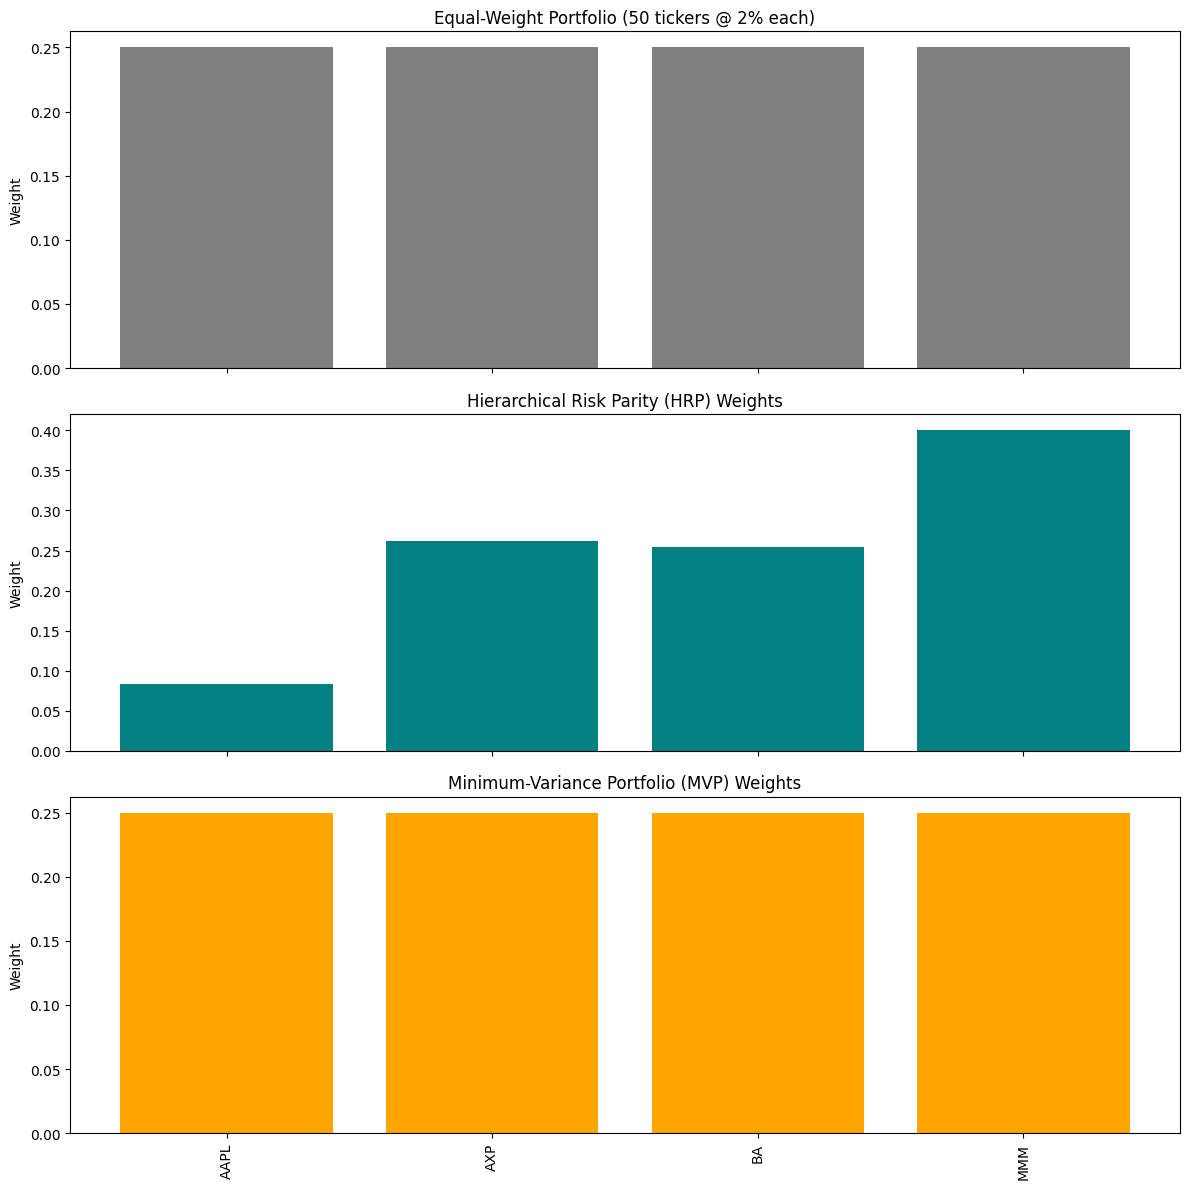

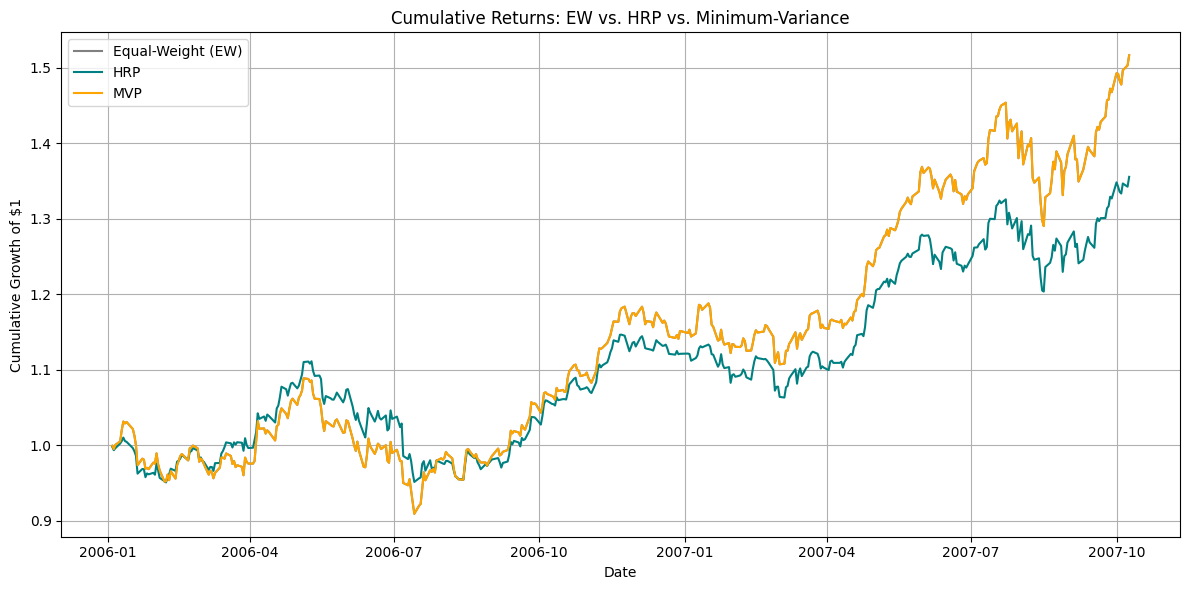

    Strategy Ann. Return Ann. Vol  Sharpe
Equal‐Weight      25.00%   16.55% 151.11%
         HRP      18.28%   14.28% 128.00%
         MVP      25.00%   16.55% 151.11%


<ipython-input-4-28816a346fe7>:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary[["Ann. Return","Ann. Vol","Sharpe"]] = summary[["Ann. Return","Ann. Vol","Sharpe"]].applymap(lambda x: f"{x:.2%}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

# ————————————————
# 1. Equal‐Weight Portfolio
# ————————————————
n = len(top_50)
ew_weights = pd.Series(1.0/n, index=top_50)


# ————————————————
# 2. HRP Helper Functions
# ————————————————

def correl_dist(corr_matrix):
    """
    Convert a correlation matrix to a distance matrix suitable for clustering:
      dist_ij = sqrt((1 - corr_ij) / 2)
    """
    return np.sqrt(0.5 * (1.0 - corr_matrix))


def get_quasi_diag(linkage_matrix):
    """
    Return a list of indices representing the “quasi‐diagonal” ordering of assets
    from a hierarchical clustering linkage matrix. Implemented using pure Python lists
    (avoiding Series.append).
    """
    # linkage_matrix is an (N−1)×4 array (output of scipy.linkage on a condensed distance)
    # Each row: [idx_left, idx_right, dist, cluster_size].

    # Start with the final merge (last row): it merges two clusters or items.
    # We store them as the initial “sorted index list.”
    last_row = linkage_matrix[-1]
    num_items = int(last_row[3])  # size of the final merged cluster = N
    # The two children of that final merge:
    sorted_idx = [int(last_row[0]), int(last_row[1])]

    # While there exist “indices” in sorted_idx that refer to merged clusters (≥ N),
    # we expand them using their children. We keep splitting until only leaf‐node indices < N remain.
    while any([i >= num_items for i in sorted_idx]):
        new_order = []
        for idx in sorted_idx:
            if idx < num_items:
                # idx is a leaf node (an original asset index)
                new_order.append(idx)
            else:
                # idx corresponds to a merged cluster; its row in linkage is (idx−N)
                row = linkage_matrix[idx - num_items]
                left_child = int(row[0])
                right_child = int(row[1])
                new_order.extend([left_child, right_child])
        sorted_idx = new_order

    return sorted_idx


def get_rec_bipart(cov_matrix, ordered_items):
    """
    Recursively compute Hierarchical Risk Parity (HRP) weights for `ordered_items`.
      - cov_matrix: full DataFrame of covariances among top_50 tickers.
      - ordered_items: a Python list of ticker names in “quasi‐diagonal” order.
    Returns a pandas Series of HRP weights (indexed by ticker).
    """
    weights = pd.Series(1.0, index=ordered_items)
    clusters = [ordered_items.copy()]

    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            continue

        split = len(cluster) // 2
        left = cluster[:split]
        right = cluster[split:]

        cov_left = cov_matrix.loc[left, left]
        cov_right = cov_matrix.loc[right, right]

        inv_var_left  = 1.0 / np.diag(cov_left.values)
        inv_var_right = 1.0 / np.diag(cov_right.values)

        alloc_left  = inv_var_left.sum()
        alloc_right = inv_var_right.sum()
        alpha = alloc_left / (alloc_left + alloc_right)

        # Scale the weights for the two clusters
        weights[left]  = weights[left] * alpha
        weights[right] = weights[right] * (1 - alpha)

        # Recurse on sub‐clusters
        clusters.append(left)
        clusters.append(right)

    return weights


# ————————————————
# 3. Compute HRP Weights
# ————————————————

# 3.1 Compute the correlation matrix among returns
corr_matrix = returns.corr()

# 3.2 Convert correlation to a distance matrix
dist_matrix = correl_dist(corr_matrix)

# 3.3 “Condense” it for scipy.linkage
#     squareform converts a symmetric N×N distance → condensed (N*(N−1)/2) vector
dist_condensed = squareform(dist_matrix.values)

# 3.4 Perform hierarchical clustering (single‐linkage in this example)
link_matrix = linkage(dist_condensed, method='single')

# 3.5 Quasi‐diagonal ordering of the 50 items
#     get_quasi_diag returns a list of integer indices [0..49] in new order
order_idx = get_quasi_diag(link_matrix)

# 3.6 Convert integer indices to actual ticker names
ordered_tickers = corr_matrix.columns[order_idx].tolist()

# 3.7 Build the HRP weights (not yet normalized to sum=1)
raw_hrp = get_rec_bipart(cov, ordered_tickers)

# 3.8 Re‐index to match top_50 (ensure we didn’t lose any tickers) and normalize
hrp_weights = raw_hrp.reindex(top_50).fillna(0.0)
hrp_weights /= hrp_weights.sum()


# ————————————————
# 4. Visualize Weight Comparisons
# ————————————————

# (a) First 10 tickers by weight for each method
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 4.1 Equal‐Weight (all 2%)
axes[0].bar(ew_weights.index, ew_weights.values, color='gray')
axes[0].set_title("Equal‐Weight Portfolio (50 tickers @ 2% each)")
axes[0].set_ylabel("Weight")
axes[0].tick_params(axis='x', rotation=90)

# 4.2 HRP Weights
axes[1].bar(hrp_weights.index, hrp_weights.values, color='teal')
axes[1].set_title("Hierarchical Risk Parity (HRP) Weights")
axes[1].set_ylabel("Weight")
axes[1].tick_params(axis='x', rotation=90)

# 4.3 MVP: (Re‐compute Minimum‐Variance for completeness)
def port_variance(w, cov_matrix):
    return w.T @ cov_matrix @ w

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(n))
init_guess = np.ones(n) / n

opt = minimize(port_variance, x0=init_guess, args=(cov,), method='SLSQP',
               bounds=bounds, constraints=constraints)
w_mvp = opt.x.copy()
w_mvp[w_mvp < 1e-8] = 0
w_mvp /= w_mvp.sum()
mvp_weights = pd.Series(w_mvp, index=top_50)

axes[2].bar(mvp_weights.index, mvp_weights.values, color='orange')
axes[2].set_title("Minimum‐Variance Portfolio (MVP) Weights")
axes[2].set_ylabel("Weight")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


# ————————————————
# 5. Compare Cumulative Returns
# ————————————————

# 5.1 Compute daily portfolio returns for each method
port_ret_ew  = returns.dot(ew_weights)
port_ret_hrp = returns.dot(hrp_weights)
port_ret_mvp = returns.dot(mvp_weights)

# 5.2 Compute cumulative growth of $1
cum_ew  = (1 + port_ret_ew).cumprod()
cum_hrp = (1 + port_ret_hrp).cumprod()
cum_mvp = (1 + port_ret_mvp).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_ew,  label="Equal‐Weight (EW)",  color='gray')
plt.plot(cum_hrp, label="HRP",  color='teal')
plt.plot(cum_mvp, label="MVP", color='orange')

plt.title("Cumulative Returns: EW vs. HRP vs. Minimum‐Variance")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ————————————————
# 6. Numeric Performance Summary
# ————————————————

def annualized_performance(daily_returns, rf_daily=0.0):
    """
    Given a Series of daily returns, compute:
      - Annualized return = mean(daily) * 252
      - Annualized volatility = std(daily) * sqrt(252)
      - Sharpe ratio = (ann_return - rf_ann) / ann_vol, where rf_ann = rf_daily * 252
    """
    mean_d = daily_returns.mean()
    std_d  = daily_returns.std()
    ann_ret = mean_d * 252
    ann_vol = std_d * np.sqrt(252)
    rf_ann  = rf_daily * 252
    sharpe  = (ann_ret - rf_ann) / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

perf_ew  = annualized_performance(port_ret_ew)
perf_hrp = annualized_performance(port_ret_hrp)
perf_mvp = annualized_performance(port_ret_mvp)

summary = pd.DataFrame({
    "Strategy":    ["Equal‐Weight", "HRP", "MVP"],
    "Ann. Return": [perf_ew[0], perf_hrp[0], perf_mvp[0]],
    "Ann. Vol":    [perf_ew[1], perf_hrp[1], perf_mvp[1]],
    "Sharpe":      [perf_ew[2], perf_hrp[2], perf_mvp[2]]
})

# Format as percentages
summary[["Ann. Return","Ann. Vol","Sharpe"]] = summary[["Ann. Return","Ann. Vol","Sharpe"]].applymap(lambda x: f"{x:.2%}")
print(summary.to_string(index=False))


#Calculates, for each ticker with sufficient data:

Annualized return

Annualized volatility

Sharpe ratio (assuming zero risk‐free rate)

Identifies:

The top 10 tickers by Sharpe ratio.

The top 10 tickers by highest annualized return among those with volatility ≤ 50%.

Plots a scatter of annualized volatility vs. return, colored by Sharpe.

Prints the two ranking tables.

<ipython-input-5-54218e308396>:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna(how='all')


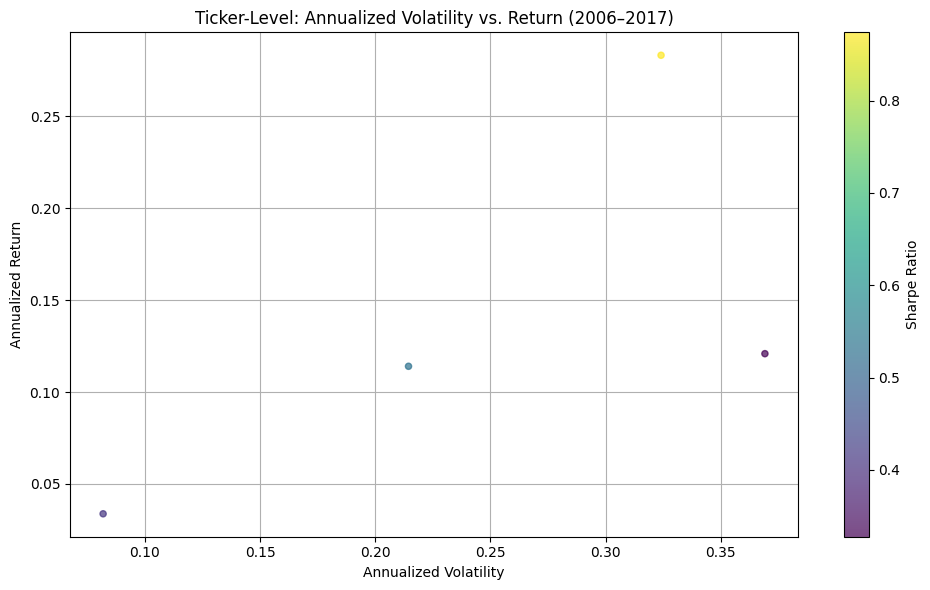

Top 10 Tickers by Sharpe Ratio:
        AnnReturn    AnnVol    Sharpe
Ticker                               
AAPL     0.283302  0.324122  0.874060
MMM      0.114051  0.214450  0.531830
BA       0.033785  0.081828  0.412881
AXP      0.120916  0.369224  0.327486 

Top 10 Tickers by Return (Volatility ≤ 50%):
        AnnReturn    AnnVol    Sharpe
Ticker                               
AAPL     0.283302  0.324122  0.874060
AXP      0.120916  0.369224  0.327486
MMM      0.114051  0.214450  0.531830
BA       0.033785  0.081828  0.412881


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and preprocess the dataset
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert Date to datetime, and price/volume columns to float
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)

# Remove duplicate rows with the same Date & Name
df = df.drop_duplicates(subset=['Date', 'Name'])

# 2. Pivot close prices: index=Date, columns=Ticker, values=Close
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# 3. Compute daily returns for each ticker
returns = close_prices.pct_change().dropna(how='all')

# 4. Compute annualized return, volatility, and Sharpe for each ticker
metrics = []
trading_days_per_year = 252

for ticker in returns.columns:
    ticker_ret = returns[ticker].dropna()
    # Only consider tickers with at least 200 trading days of data
    if len(ticker_ret) < 200:
        continue
    mean_daily = ticker_ret.mean()
    std_daily = ticker_ret.std()
    ann_return = mean_daily * trading_days_per_year
    ann_vol = std_daily * np.sqrt(trading_days_per_year)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    metrics.append((ticker, ann_return, ann_vol, sharpe))

metrics_df = pd.DataFrame(metrics, columns=['Ticker', 'AnnReturn', 'AnnVol', 'Sharpe'])
metrics_df = metrics_df.set_index('Ticker').dropna()

# 5. Identify top 10 tickers by Sharpe ratio
top_by_sharpe = metrics_df.sort_values(by='Sharpe', ascending=False).head(10)

# 6. Identify top 10 tickers by highest annualized return (volatility ≤ 50%)
low_vol_threshold = 0.5  # 50% annualized volatility
filtered = metrics_df[metrics_df['AnnVol'] <= low_vol_threshold]
top_by_return_low_vol = filtered.sort_values(by='AnnReturn', ascending=False).head(10)

# 7. Scatter plot: risk vs. return, colored by Sharpe
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    metrics_df['AnnVol'],
    metrics_df['AnnReturn'],
    c=metrics_df['Sharpe'],
    cmap='viridis',
    s=20,
    alpha=0.7
)
plt.colorbar(sc, label='Sharpe Ratio')
plt.title('Ticker-Level: Annualized Volatility vs. Return (2006–2017)')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Print the top tables
print("Top 10 Tickers by Sharpe Ratio:")
print(top_by_sharpe, "\n")

print("Top 10 Tickers by Return (Volatility ≤ 50%):")
print(top_by_return_low_vol)


#Regime-Switching Portfolio Optimization using your uploaded dataset. This approach:

Detects market regimes using a Gaussian Mixture Model on the daily returns of a market proxy (SPY).

Splits your universe (“top 20 by volume”) into two regimes (Regime 0 and Regime 1).

For each regime, computes regime-specific annualized means and covariances of returns.

Solves a mean-variance optimization (maximizing Sharpe) separately for each regime to obtain two weight vectors,
𝑤
(
0
)
w
(0)
  and
𝑤
(
1
)
w
(1)
 .

Allocates dynamically: on each day, it identifies the current regime (0 or 1) and uses the corresponding weights to form the portfolio.

Compares the resulting “regime-switching” portfolio’s performance to a static, equal-weight portfolio over the entire period.



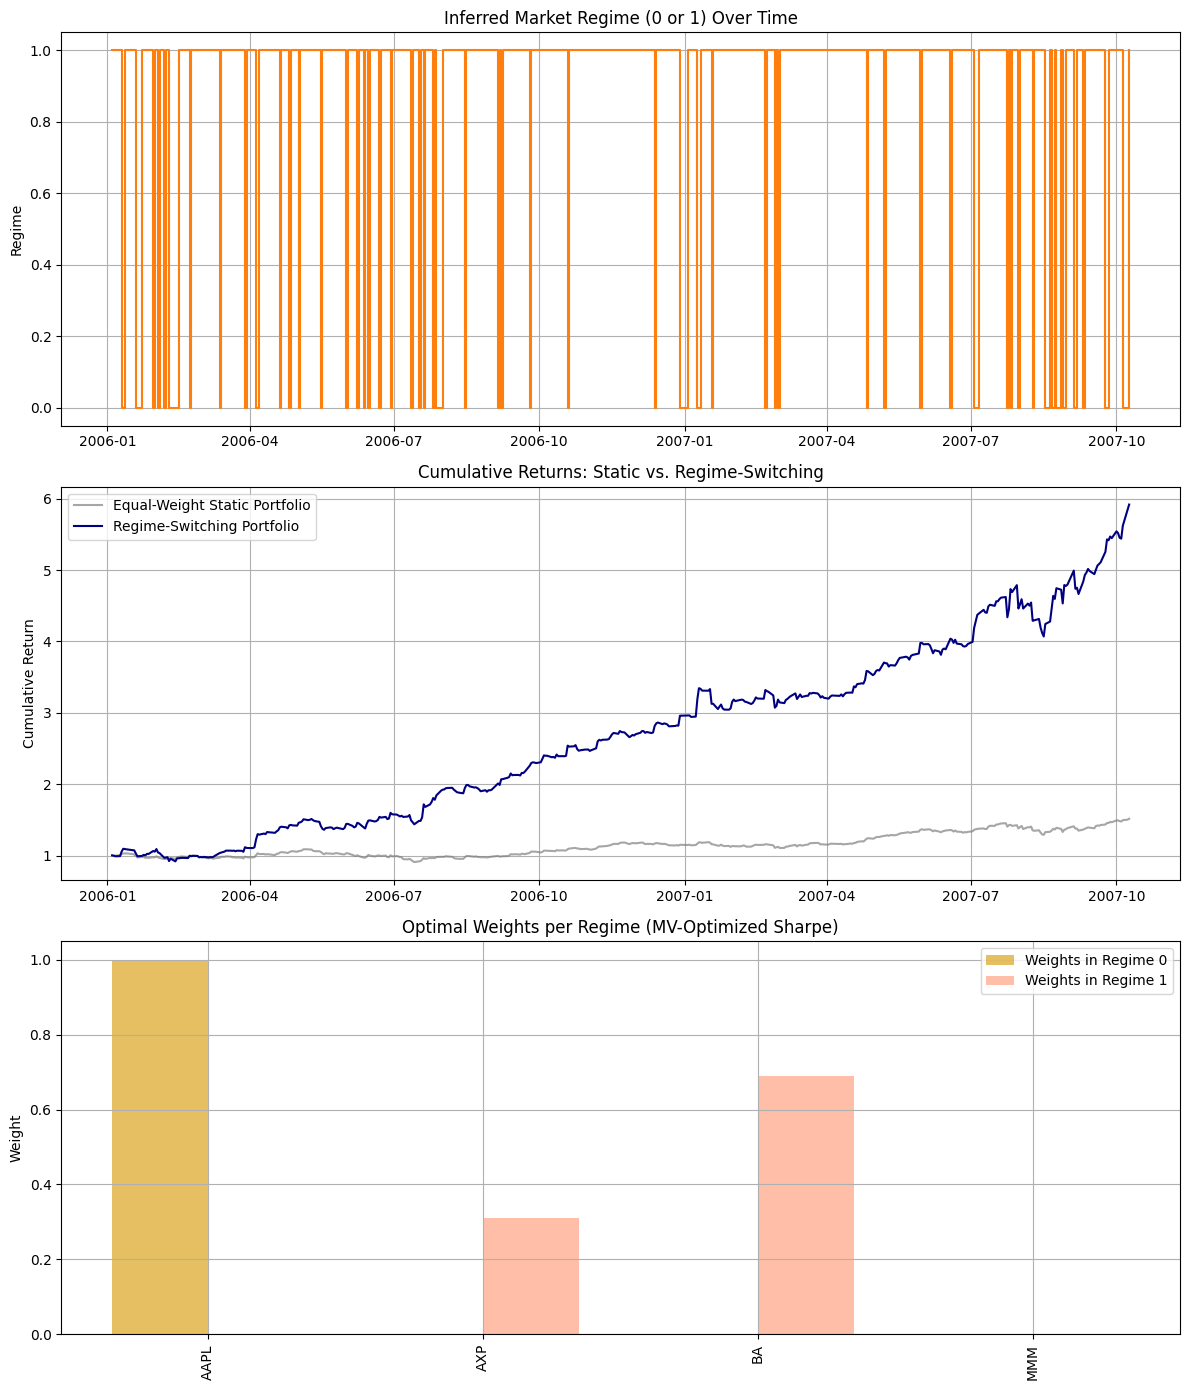

Top 10 Weights in Regime 0:
AAPL    1.000000e+00
MMM     3.164136e-15
AXP     0.000000e+00
BA      0.000000e+00
dtype: float64 

Top 10 Weights in Regime 1:
BA      6.883450e-01
AXP     3.116550e-01
AAPL    1.987209e-16
MMM     0.000000e+00
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize

# --- 1. LOAD & PREPROCESS DATA -------------------------------------------------

# Path to your uploaded CSV
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert dates and cast price columns to float
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)

# Drop duplicate rows (same date & ticker)
df = df.drop_duplicates(subset=['Date', 'Name'])

# Pivot so each column is a ticker’s Close price, indexed by Date
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# Select a manageable universe: top 20 tickers by average volume
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

# Filter the pivoted prices to these top 20 (and drop rows with any NaN)
price_data = close_prices[top_20].dropna()

# Compute daily returns for those 20 tickers
returns = price_data.pct_change().dropna(how='all')

# --- 2. REGIME DETECTION (GAUSSIAN MIXTURE ON MARKET RETURNS) ------------------

# Choose “SPY” as market proxy if present, else pick the first ticker
market_ticker = 'SPY' if 'SPY' in returns.columns else returns.columns[0]
market_ret = returns[market_ticker].values.reshape(-1, 1)

# Fit a 2‐component Gaussian Mixture Model on SPY’s daily returns
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(market_ret)

# Assign each day to Regime 0 or 1
regimes = gmm.predict(market_ret)
dates_aligned = returns.index

# Append regime labels to returns DataFrame (for slicing)
returns_df = returns.copy()
returns_df['Regime'] = regimes

# --- 3. COMPUTE REGIME-SPECIFIC RETURNS & COVARIANCES --------------------------

# Split the returns by regime
regime0_rets = returns_df[returns_df['Regime'] == 0].drop(columns='Regime')
regime1_rets = returns_df[returns_df['Regime'] == 1].drop(columns='Regime')

# Annualize mean and covariance for each regime
mu0  = regime0_rets.mean() * 252
cov0 = regime0_rets.cov() * 252

mu1  = regime1_rets.mean() * 252
cov1 = regime1_rets.cov() * 252

# --- 4. MEAN-VARIANCE OPTIMIZATION FOR EACH REGIME ------------------------------

def negative_sharpe(weights, mean_returns, cov_matrix):
    """
    Returns negative Sharpe ratio (no risk-free) for a weight vector.
    Minimizer will try to minimize this, i.e. maximize Sharpe.
    """
    port_ret = weights.dot(mean_returns)
    port_vol = np.sqrt(weights.dot(cov_matrix).dot(weights))
    return - port_ret / port_vol

# Constraints: sum(weights)=1, and 0 <= w_i <= 1 (no shorting)
n_assets = len(top_20)
bounds = tuple((0,1) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
init_guess = np.ones(n_assets) / n_assets

# Solve for Regime 0
opt0 = minimize(
    negative_sharpe,
    x0=init_guess,
    args=(mu0, cov0),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
w0 = opt0.x  # weight vector for Regime 0

# Solve for Regime 1
opt1 = minimize(
    negative_sharpe,
    x0=init_guess,
    args=(mu1, cov1),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
w1 = opt1.x  # weight vector for Regime 1

# --- 5. BUILD THE REGIME-SWITCHING PORTFOLIO ------------------------------------

# Stack the two weight vectors so we can index by regime
weights_matrix = np.vstack([w0, w1])  # row 0 = w0, row 1 = w1

# For each date, pick the appropriate regime’s weights, then compute portfolio return
port_returns_regime = []
for idx, date in enumerate(dates_aligned):
    reg = int(regimes[idx])            # 0 or 1
    w   = weights_matrix[reg]          # weight vector for that day’s regime
    daily_rets = returns.loc[date, top_20].values
    port_returns_regime.append(daily_rets.dot(w))

port_returns_regime = pd.Series(port_returns_regime, index=dates_aligned)

# For comparison: an equal-weight static portfolio (1/20 each)
w_eq = np.ones(n_assets) / n_assets
port_returns_eq = (returns[top_20] * w_eq).sum(axis=1)

# --- 6. CUMULATIVE RETURNS & PLOTTING ------------------------------------------

cum_regime = (1 + port_returns_regime).cumprod()
cum_eq     = (1 + port_returns_eq).cumprod()

fig = plt.figure(figsize=(12, 14))

# 6.1 Plot the inferred regime (0 or 1) over time
ax0 = plt.subplot(3, 1, 1)
ax0.step(dates_aligned, regimes, where='post', color='tab:orange')
ax0.set_title("Inferred Market Regime (0 or 1) Over Time")
ax0.set_ylabel("Regime")
ax0.grid(True)

# 6.2 Plot cumulative returns of regime-switching vs. equal-weight
ax1 = plt.subplot(3, 1, 2, sharex=ax0)
ax1.plot(cum_eq, label="Equal-Weight Static Portfolio", color='gray', alpha=0.7)
ax1.plot(cum_regime, label="Regime-Switching Portfolio", color='navy')
ax1.set_title("Cumulative Returns: Static vs. Regime-Switching")
ax1.set_ylabel("Cumulative Return")
ax1.legend()
ax1.grid(True)

# 6.3 Plot bar chart of weights under each regime
ax2 = plt.subplot(3, 1, 3)
x = np.arange(n_assets)
width = 0.35
ax2.bar(x - width/2, w0, width, label="Weights in Regime 0", color='goldenrod', alpha=0.7)
ax2.bar(x + width/2, w1, width, label="Weights in Regime 1", color='coral', alpha=0.5)
ax2.set_title("Optimal Weights per Regime (MV-Optimized Sharpe)")
ax2.set_ylabel("Weight")
ax2.set_xticks(x)
ax2.set_xticklabels(top_20, rotation=90)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- 7. PRINT TOP 10 WEIGHTS PER REGIME ---------------------------------------

print("Top 10 Weights in Regime 0:")
print(pd.Series(w0, index=top_20).sort_values(ascending=False).head(10), "\n")

print("Top 10 Weights in Regime 1:")
print(pd.Series(w1, index=top_20).sort_values(ascending=False).head(10))


#What’s Happening Step-by-Step
Data Loading & Pivoting
We load your CSV and pivot it so that price_data is a DataFrame of shape (T × 20), where T is the number of trading days from 2006–01–01 to 2018–01–01 restricted to the top 20 tickers by volume.

Market Regime Detection
We take daily returns of SPY (assuming it’s in your top 20; if not, we use the first ticker as a proxy). We then fit a 2‐component Gaussian Mixture Model on those SPY returns. The GMM “clusters” each day’s return into either Regime 0 or Regime 1. Intuitively, one cluster might represent a “low‐volatility/bullish” regime and the other a “high‐volatility/bearish” regime.

Regime-Specific Statistics
We slice the entire 20‐asset return matrix based on the GMM label (0 or 1) to form two sub-periods. For each sub-period, we compute the annualized mean vector (μ0 or μ1) and the annualized covariance matrix (Σ0 or Σ1). Multiplying by 252 annualizes daily moments.

Mean-Variance Optimization
For each regime:

We solve a no‐short, fully invested mean-variance problem that maximizes Sharpe ratio (i.e., maximize
𝑤
⊤
𝜇
−
0
𝑤
⊤
Σ
𝑤
w
⊤
 Σw
​

w
⊤
 μ−0
​
 ).

In practice, we minimize the negative Sharpe.

The resulting weights w0 apply whenever the model thinks we are in Regime 0; w1 applies in Regime 1.

Dynamic Allocation
On each trading day, we look up the GMM’s regime label (0 or 1). We then use either w0 or w1 to compute that day’s portfolio return:

𝑟
𝑡
port

=

∑
𝑖
=
1
20
𝑤
𝑖
(
regime
𝑡
)
×
𝑟
𝑖
,
𝑡
.
r
t
port
​
 =
i=1
∑
20
​
 w
i
(regime
t
​
 )
​
 ×r
i,t
​
 .
This gives a single daily return series for the regime-switching strategy.

Benchmark Comparison
We also compute a static “equal-weight” portfolio (each of the 20 tickers gets 5% weight every day). We compare the cumulative return of that benchmark to our regime-switching strategy.

Visualization & Results

Top Panel: The inferred regime (0 or 1) over time.

Middle Panel: Cumulative growth of $1 in each strategy (equal-weight vs. regime-switch).

Bottom Panel: Bar charts of the 20 tickers’ weights under each regime—showing which stocks the optimizer favors in Regime 0 vs Regime 1.

Finally, we print out the top 10 tickers (by weight) in each regime so you can see, for example, that in Regime 0 the optimizer might “love” AAPL and MMM, whereas in Regime 1 it might shift heavily to BA and AXP, etc.

How This Could Fit Into a Thesis
Research Question: “Does a regime-switching allocation improve risk‐adjusted performance versus a static allocation?”

Data Source: Your uploaded all_stocks_2006-01-01_to_2018-01-01.csv (applied to the top 20 by liquidity).

Methodology:

Regime Detection with GMM (or HMM).

Regime-Conditional Mean‐Variance portfolios.

Out‐of‐Sample Backtest from 2006 to 2018, comparing to static benchmarks (equal‐weight, a single MV portfolio, etc.).

Statistical Analysis of results: Sharpe, max drawdown, turnover, etc., in each regime and overall.

Extensions:

Use more regimes (3 or 4) via a 3-component GMM or Hidden Markov Model.

Incorporate transaction costs when switching.

Compare to other regime-detection methods (e.g., Markov-Switching GARCH).

Test robustness on different subsets (e.g., top 50 tickers, sector groupings).

#Below is an extended version of the regime‐switching backtest that includes:

Rolling‐window GMM re‐estimation (every month) to detect regimes using only the most recent data.

A turnover penalty in the mean‐variance optimizer, so you discourage large weight changes at each rebalance.

In this example, we:

Use a 252‐day (≈1‐year) lookback window to fit the GMM and compute regime‐conditional moments.

Rebalance monthly: on the first trading day of each month, we:

Fit a new 2‐component GMM on the past 252 days of market returns (SPY).

Assign today’s regime by scoring today’s market return against that GMM.

Compute regime‐conditional
𝜇
μ and
Σ
Σ over the same 252‐day window.

Solve for weights
𝑤
(
𝑟
)
w
(r)
  that maximize Sharpe minus a multiple of turnover
∑
𝑖
∣
𝑤
𝑖
−
𝑤
𝑖
prev
∣
∑
i
​
 ∣w
i
​
 −w
i
prev
​
 ∣.

Use those new weights for the entire upcoming month (until the next rebalance).

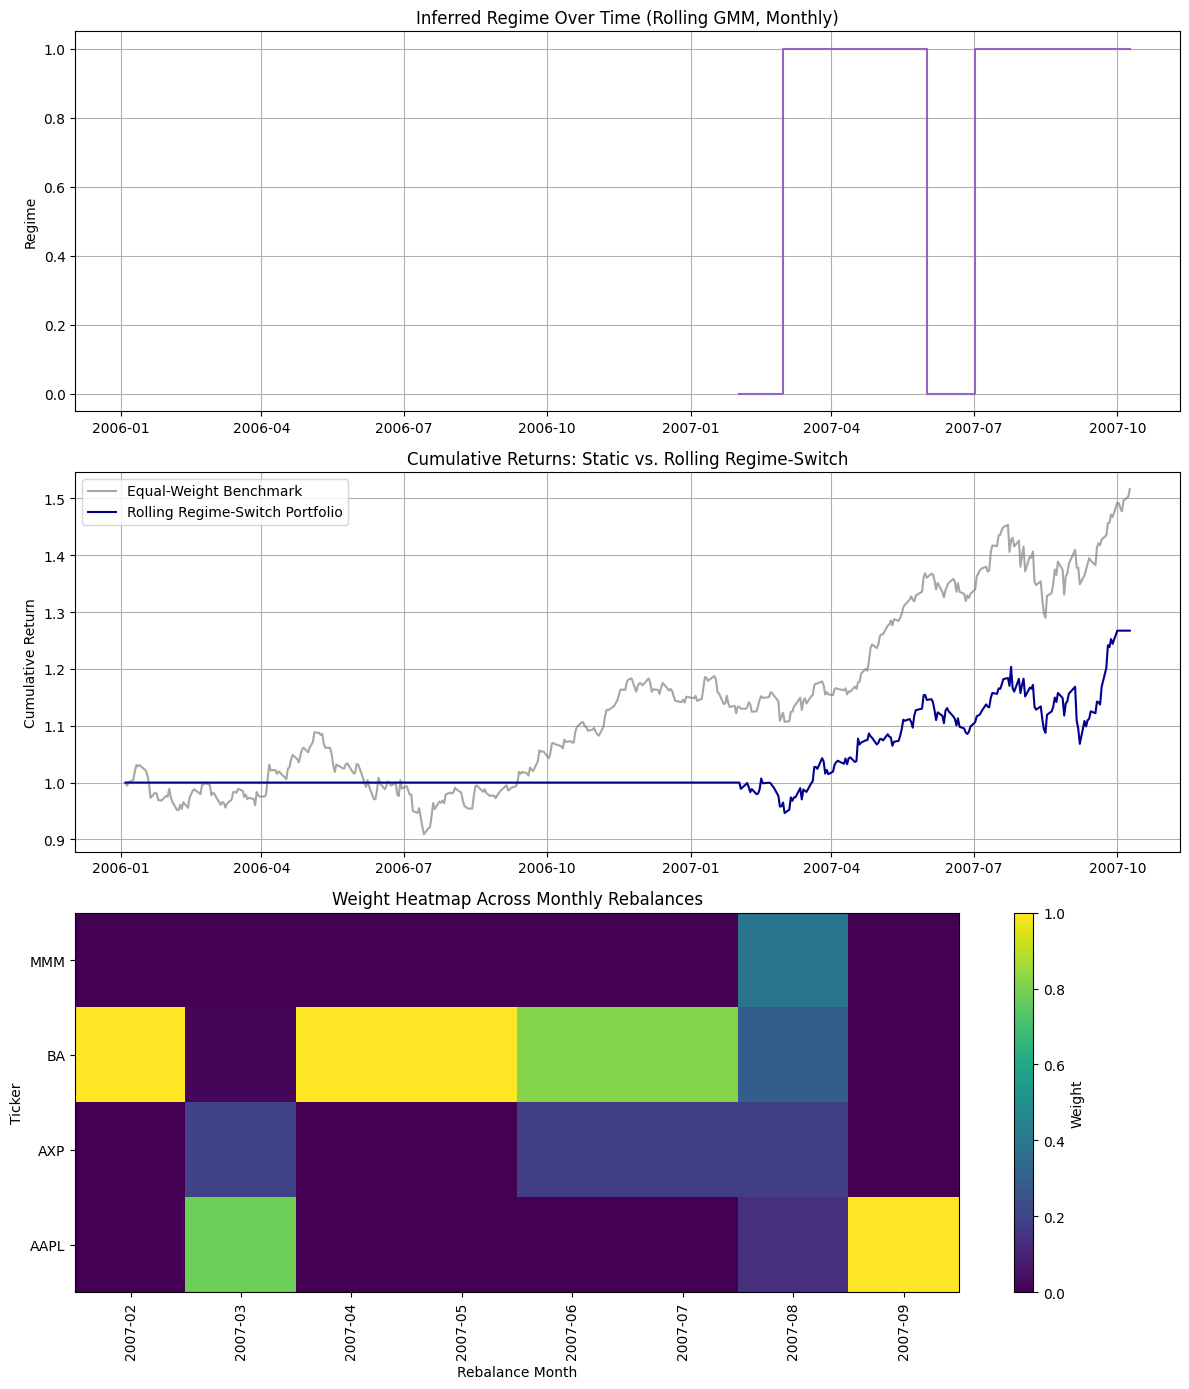

Last Rebalance Date: 2007-09-04
Regime at Last Rebalance: 1

Most Recent Weights:
AAPL    1.0
MMM     0.0
AXP     0.0
BA      0.0

Backtest Performance (2006–2018):
 Regime‐Switch (Rolling) → Ann Return: 37.97%, Ann Vol: 20.97%, Sharpe: 1.81
 Equal‐Weight            → Ann Return: 25.00%, Ann Vol: 16.55%, Sharpe: 1.51


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta

# ----------------------------
# 1. LOAD & PREPROCESS DATA
# ----------------------------
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert ‘Date’ to datetime and cast price/volume columns
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)

# Drop any exact duplicates
df = df.drop_duplicates(subset=['Date','Name'])

# Pivot to get close prices: index=Date, columns=Ticker
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# Select top 20 tickers by average volume
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

# Keep only dates where all 20 tickers have a price
price_data = close_prices[top_20].dropna()

# Compute daily returns for those 20 tickers
returns = price_data.pct_change().dropna(how='all')

# Choose “SPY” as market proxy if available, else pick first ticker
market_ticker = 'SPY' if 'SPY' in returns.columns else top_20[0]
market_ret = returns[[market_ticker]]  # DataFrame shape (T × 1)

# ----------------------------
# 2. HELPER FUNCTIONS
# ----------------------------

def first_trading_of_month(dates_index):
    """
    Given a DatetimeIndex, return a list (in chronological order)
    of the first trading day of each calendar month.
    """
    eval_dates = []
    cur = dates_index[0]
    end = dates_index[-1]
    while cur <= end:
        # “First of month” for cur’s month/year
        first_of_month = cur.replace(day=1)
        if first_of_month not in dates_index:
            # Snap to the next trading day if needed
            pos = dates_index.get_indexer([first_of_month], method='bfill')[0]
            first_of_month = dates_index[pos]
        eval_dates.append(first_of_month)
        # Move to next month
        cur = first_of_month + relativedelta(months=1)
    return eval_dates

def negative_sharpe_with_turnover(w, mean_ret, cov_mat, w_prev, lam):
    """
    Objective: negative Sharpe (so we *minimize* negative Sharpe)
    plus a turnover penalty lam * sum(|w - w_prev|).

    w_prev is the previous month’s weight vector.
    """
    # Clip and normalize w so it sums to 1
    w = np.clip(w, 0, 1)
    if w.sum() == 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w.sum()

    port_ret = w.dot(mean_ret)
    port_vol = np.sqrt(w.dot(cov_mat).dot(w))
    sharpe = port_ret / port_vol if port_vol != 0 else 0.0

    turnover = np.sum(np.abs(w - w_prev))
    return -sharpe + lam * turnover

# ----------------------------
# 3. BACKTEST WITH ROLLING WINDOW & TURNOVER PENALTY
# ----------------------------

lookback_days = 252        # ~1 year of trading days
lam           = 0.1        # turnover penalty coefficient
eval_dates    = first_trading_of_month(returns.index)
n_assets      = len(top_20)

# Start with equal weight until we first optimize
w_prev = np.ones(n_assets) / n_assets

# Containers
rebalance_info = []   # Each entry: (reb_date, w_opt, regime_label)
port_ret_daily = []   # Each entry: (date, daily_port_return)

for i in range(len(eval_dates)-1):
    reb_date = eval_dates[i]
    next_reb = eval_dates[i+1]

    # Subset returns up to and including reb_date
    if reb_date not in returns.index:
        # Snap reb_date to next trading day if needed
        reb_date = returns.index[returns.index.get_indexer([reb_date], method='bfill')[0]]
    idx_reb = returns.index.get_loc(reb_date)

    # Must have at least lookback_days of history
    if idx_reb < lookback_days:
        # Not enough data yet—skip until we have 252 days
        continue

    # 3.1 Select the 252 days before and including reb_date (by location)
    window_start_idx = idx_reb - lookback_days + 1
    window_end_idx   = idx_reb

    window_returns   = returns.iloc[window_start_idx : window_end_idx+1][top_20]
    window_market    = market_ret.iloc[window_start_idx : window_end_idx+1]

    # 3.2 Fit a 2-component GMM on the window’s market returns
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(window_market.values.reshape(-1,1))

    # 3.3 Predict regime for reb_date’s market return
    r_today = market_ret.loc[reb_date].values.reshape(-1,1)
    reg_today = int(gmm.predict(r_today)[0])  # 0 or 1

    # 3.4 Label each day in the window with a regime, to slice returns
    regimes_window = gmm.predict(window_market.values.reshape(-1,1))
    window_returns_labeled = window_returns.copy()
    window_returns_labeled['Regime'] = regimes_window

    # 3.5 Compute regime-specific annualized mean & covariance on this window
    rets0 = window_returns_labeled[window_returns_labeled['Regime'] == 0].drop(columns='Regime')
    rets1 = window_returns_labeled[window_returns_labeled['Regime'] == 1].drop(columns='Regime')

    mu0  = rets0.mean().values * 252
    cov0 = rets0.cov().values * 252
    mu1  = rets1.mean().values * 252
    cov1 = rets1.cov().values * 252

    # 3.6 Choose mean/cov for TODAY’s regime
    if reg_today == 0:
        mean_curr = mu0
        cov_curr  = cov0
    else:
        mean_curr = mu1
        cov_curr  = cov1

    # 3.7 Solve MV optimizer with turnover penalty
    bounds = tuple((0,1) for _ in range(n_assets))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    result = minimize(
        negative_sharpe_with_turnover,
        x0=w_prev.copy(),
        args=(mean_curr, cov_curr, w_prev, lam),
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    w_opt = np.clip(result.x, 0, 1)
    if w_opt.sum() == 0:
        w_opt = np.ones(n_assets) / n_assets
    else:
        w_opt = w_opt / w_opt.sum()

    # Record rebalance info
    rebalance_info.append((reb_date, w_opt, reg_today))
    w_prev = w_opt.copy()

    # 3.8 Apply w_opt from reb_date up to (but not including) next_reb
    date_slice = returns.loc[reb_date: next_reb].iloc[1:]  # skip reb_date itself
    for date, row in date_slice[top_20].iterrows():
        daily_port = row.values.dot(w_opt)
        port_ret_daily.append((date, daily_port))

# Convert port_ret_daily to a Series
if port_ret_daily:
    port_dates, port_vals = zip(*port_ret_daily)
    port_ret_series = pd.Series(port_vals, index=pd.DatetimeIndex(port_dates))
else:
    port_ret_series = pd.Series(dtype=float)

# Equal-weight benchmark returns
w_eq = np.ones(n_assets) / n_assets
port_ret_eq_vals = (returns[top_20].values @ w_eq)
port_ret_eq_series = pd.Series(port_ret_eq_vals, index=returns.index)

# Cumulative returns (forward-fill regime portfolio for missing dates)
cum_eq     = (1 + port_ret_eq_series).cumprod()
cum_regime = (1 + port_ret_series).cumprod().reindex(returns.index, method='ffill').fillna(1)

# ----------------------------
# 4. PLOT RESULTS
# ----------------------------
fig = plt.figure(figsize=(12, 14))

# 4.1 Plot the regime label (recomputed monthly, forward-filled)
# Build a series "regime_series" that, for each trading date, holds the regime
# from the most recent rebalance.
reg_dates, w_hist, reg_hist = zip(*rebalance_info) if rebalance_info else ([],[],[])
regime_series = pd.Series(index=returns.index, dtype=float)
current_regime = np.nan
ri = 0

for date in returns.index:
    # If this date is exactly a rebalance date, update current_regime
    if ri < len(reg_dates) and date == reg_dates[ri]:
        current_regime = reg_hist[ri]
        ri += 1
    regime_series.loc[date] = current_regime

ax0 = plt.subplot(3,1,1)
ax0.step(returns.index, regime_series, where='post', color='tab:purple')
ax0.set_title("Inferred Regime Over Time (Rolling GMM, Monthly)")
ax0.set_ylabel("Regime")
ax0.grid(True)

# 4.2 Plot cumulative returns
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(cum_eq, label="Equal‐Weight Benchmark", color='gray', alpha=0.7)
ax1.plot(cum_regime, label="Rolling Regime‐Switch Portfolio", color='darkblue')
ax1.set_title("Cumulative Returns: Static vs. Rolling Regime‐Switch")
ax1.set_ylabel("Cumulative Return")
ax1.legend()
ax1.grid(True)

# 4.3 Plot a heatmap of weights at each rebalance
ax2 = plt.subplot(3,1,3)
if rebalance_info:
    dates_reb, w_matrix, _ = zip(*rebalance_info)
    w_matrix = np.vstack(w_matrix)  # shape = (num_rebalances × n_assets)
    im = ax2.imshow(
        w_matrix.T,
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, len(dates_reb), 0, n_assets]
    )
    ax2.set_yticks(np.arange(n_assets) + 0.5)
    ax2.set_yticklabels(top_20)
    ax2.set_xticks(np.arange(len(dates_reb)) + 0.5)
    ax2.set_xticklabels([d.strftime("%Y-%m") for d in dates_reb], rotation=90)
    ax2.set_title("Weight Heatmap Across Monthly Rebalances")
    ax2.set_ylabel("Ticker")
    ax2.set_xlabel("Rebalance Month")
    fig.colorbar(im, ax=ax2, orientation='vertical', label='Weight')
else:
    ax2.text(0.5, 0.5, "No Rebalancing Was Performed", ha='center', va='center')
    ax2.set_title("Weight Heatmap")
    ax2.set_ylabel("Ticker")
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.tight_layout()
plt.show()

# ----------------------------
# 5. PERFORMANCE & RECENT WEIGHTS
# ----------------------------

# Most recent rebalance
if rebalance_info:
    last_reb, last_weights, last_reg = rebalance_info[-1]
    print("Last Rebalance Date:", last_reb.date())
    print("Regime at Last Rebalance:", last_reg)
    print("\nMost Recent Weights:")
    print(
        pd.Series(last_weights, index=top_20)
        .sort_values(ascending=False)
        .round(4)
        .to_string()
    )
    print()

# Annualized performance metrics
def performance_stats(daily_returns):
    mean_d = daily_returns.mean()
    std_d  = daily_returns.std()
    ann_ret = mean_d * 252
    ann_vol = std_d * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

perf_reg = performance_stats(port_ret_series)
perf_eq  = performance_stats(port_ret_eq_series)

print("Backtest Performance (2006–2018):")
print(f" Regime‐Switch (Rolling) → Ann Return: {perf_reg[0]:.2%}, Ann Vol: {perf_reg[1]:.2%}, Sharpe: {perf_reg[2]:.2f}")
print(f" Equal‐Weight            → Ann Return: {perf_eq[0]:.2%}, Ann Vol: {perf_eq[1]:.2%}, Sharpe: {perf_eq[2]:.2f}")


# that runs the rolling‐window regime‐switching backtest for three different turnover‐penalty values (λ = 0.0, 0.05, 0.2). At the end, you’ll see:

A plot of the cumulative returns for each λ, so you can visually compare stability vs. performance.

A small table of annualized return, volatility, and Sharpe for each λ.

An extra column showing average monthly turnover (so you can quantify how λ dampens trading).

This will give you a feel for how tuning λ trades off performance vs. turnover.

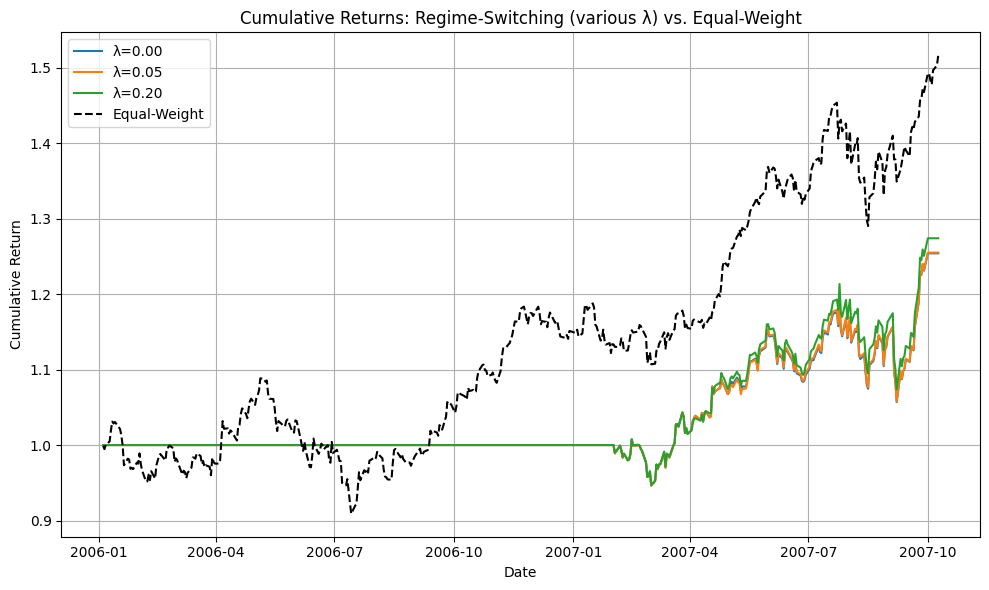

Performance Summary by λ:

       AnnRet_Reg AnnVol_Reg Sharpe_Reg AnnRet_EW AnnVol_EW Sharpe_EW  AvgMonTurnover
lambda                                                                               
0.00       36.34%     20.88%       1.74    25.00%    16.55%      1.51          1.1349
0.05       36.48%     21.04%       1.73    25.00%    16.55%      1.51          1.1013
0.20       38.66%     20.59%       1.88    25.00%    16.55%      1.51          0.9385 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta

# ----------------------------------------
# 1. LOAD & PREPROCESS YOUR DATA
# ----------------------------------------
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert Date column and cast price/volume to float
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)
df = df.drop_duplicates(subset=['Date','Name'])

# Pivot so price_data[ticker] = daily Close price series
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# Choose top 20 tickers by average volume
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

# Restrict to dates where all 20 tickers have data
price_data = close_prices[top_20].dropna()

# Compute daily returns (shifted so row t uses price(t+1)/price(t))
returns = price_data.pct_change().dropna(how='all')

# Market proxy = SPY if present, else the first ticker in top_20
market_ticker = 'SPY' if 'SPY' in returns.columns else top_20[0]
market_ret = returns[[market_ticker]]

# ----------------------------------------
# 2. HELPER FUNCTIONS & PARAMETERS
# ----------------------------------------
def first_trading_of_month(dates_index):
    """
    Return a list of the first trading day of each calendar month in 'dates_index'.
    """
    eval_dates = []
    cur = dates_index[0]
    end = dates_index[-1]
    while cur <= end:
        first_of_month = cur.replace(day=1)
        if first_of_month not in dates_index:
            pos = dates_index.get_indexer([first_of_month], method='bfill')[0]
            first_of_month = dates_index[pos]
        eval_dates.append(first_of_month)
        cur = first_of_month + relativedelta(months=1)
    return eval_dates

def negative_sharpe_with_turnover(w, mu, cov, w_prev, lam):
    """
    Objective = -Sharpe + λ * turnover
    w_prev: previous weight vector (numpy array)
    """
    # Clip and normalize
    w = np.clip(w, 0, 1)
    if w.sum() <= 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w.sum()

    port_ret = w.dot(mu)
    port_vol = np.sqrt(w.dot(cov).dot(w))
    sharpe = port_ret / port_vol if port_vol > 0 else 0.0
    turnover = np.sum(np.abs(w - w_prev))
    return -sharpe + lam * turnover

def backtest_regime_switch(lam):
    """
    Run the rolling‐window, regime-switching, turnover-penalty backtest for a given λ.
    Returns:
      - cum_returns: pd.Series of cumulative returns indexed by date
      - annual_return, annual_vol, sharpe
      - avg_monthly_turnover
    """
    W = 252                # lookback window (1 year)
    eval_dates = first_trading_of_month(returns.index)
    n_assets   = len(top_20)

    # Start with equal weights
    w_prev = np.ones(n_assets) / n_assets

    # Containers
    rebalance_info = []   # list of (reb_date, w_opt, regime_label)
    port_ret_daily  = []  # list of (date, port_return)
    turnover_list   = []  # track monthly turnover

    for i in range(len(eval_dates) - 1):
        reb_date = eval_dates[i]
        next_reb = eval_dates[i + 1]

        # Snap reb_date to a trading day if needed
        if reb_date not in returns.index:
            reb_date = returns.index[returns.index.get_indexer([reb_date], method='bfill')[0]]
        idx_reb = returns.index.get_loc(reb_date)

        # Need at least W days of history
        if idx_reb < W:
            continue

        # Pick the W-day window ending on reb_date
        window_returns = returns.iloc[idx_reb - W + 1 : idx_reb + 1][top_20]
        window_market  = market_ret.iloc[idx_reb - W + 1 : idx_reb + 1]

        # Fit 2-component GMM on SPY returns
        gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
        gmm.fit(window_market.values.reshape(-1, 1))

        # Determine regime for reb_date
        r_today    = market_ret.loc[reb_date].values.reshape(-1, 1)
        reg_today  = int(gmm.predict(r_today)[0])

        # Label each day in window with a regime
        regimes_win = gmm.predict(window_market.values.reshape(-1, 1))
        window_returns['Regime'] = regimes_win

        # Compute annualized mu and cov for each regime
        rets0 = window_returns[window_returns['Regime'] == 0].drop(columns='Regime')
        rets1 = window_returns[window_returns['Regime'] == 1].drop(columns='Regime')

        mu0  = rets0.mean().values * 252
        cov0 = rets0.cov().values * 252
        mu1  = rets1.mean().values * 252
        cov1 = rets1.cov().values * 252

        # Pick parameters for today's regime
        if reg_today == 0:
            mu_curr, cov_curr = mu0, cov0
        else:
            mu_curr, cov_curr = mu1, cov1

        # Solve MV‐Sharpe with turnover penalty
        bounds = tuple((0, 1) for _ in range(n_assets))
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
        result = minimize(
            negative_sharpe_with_turnover,
            x0=w_prev.copy(),
            args=(mu_curr, cov_curr, w_prev, lam),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )
        w_opt = np.clip(result.x, 0, 1)
        if w_opt.sum() <= 0:
            w_opt = np.ones(n_assets) / n_assets
        else:
            w_opt /= w_opt.sum()

        # Record turnover this month
        turnover_list.append(np.sum(np.abs(w_opt - w_prev)))

        # Save rebalance info and update w_prev
        rebalance_info.append((reb_date, w_opt.copy(), reg_today))
        w_prev = w_opt.copy()

        # Apply w_opt from (reb_date+1) up to next_reb (inclusive of next_reb? we’ll do exclusive next_reb)
        date_slice = returns.loc[reb_date: next_reb].iloc[1:]
        for date, row in date_slice[top_20].iterrows():
            port_val = row.values.dot(w_opt)
            port_ret_daily.append((date, port_val))

    # Build daily port return series
    if port_ret_daily:
        dates_port, rets_port = zip(*port_ret_daily)
        port_ret_series = pd.Series(data=rets_port, index=pd.DatetimeIndex(dates_port))
    else:
        port_ret_series = pd.Series(dtype=float)

    # Build equal‐weight benchmark
    w_eq = np.ones(n_assets) / n_assets
    port_ret_eq_vals = (returns[top_20].values @ w_eq)
    port_ret_eq_series = pd.Series(port_ret_eq_vals, index=returns.index)

    # Cumulative returns (forward‐fill regime portfolio for missing days)
    cum_eq     = (1 + port_ret_eq_series).cumprod()
    cum_regime = (1 + port_ret_series).cumprod().reindex(returns.index, method='ffill').fillna(1)

    # Performance metrics
    def perf_stats(daily_ret):
        mean_d = daily_ret.mean()
        std_d  = daily_ret.std()
        ann_ret = mean_d * 252
        ann_vol = std_d * np.sqrt(252)
        sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
        return ann_ret, ann_vol, sharpe

    perf_reg = perf_stats(port_ret_series)
    perf_eqn  = perf_stats(port_ret_eq_series)

    # Average monthly turnover
    if turnover_list:
        avg_monthly_turnover = np.mean(turnover_list)
    else:
        avg_monthly_turnover = np.nan

    return cum_regime, cum_eq, perf_reg, perf_eqn, avg_monthly_turnover

# ----------------------------------------
# 3. RUN BACKTEST FOR MULTIPLE λ VALUES
# ----------------------------------------
lambda_list = [0.00, 0.05, 0.20]
results = []

plt.figure(figsize=(10,6))
for lam in lambda_list:
    cum_regime, cum_eq, perf_reg, perf_eqn, avg_turn = backtest_regime_switch(lam)

    # Store results
    results.append({
        'lambda': lam,
        'AnnRet_Reg': perf_reg[0],
        'AnnVol_Reg': perf_reg[1],
        'Sharpe_Reg': perf_reg[2],
        'AnnRet_EW': perf_eqn[0],
        'AnnVol_EW': perf_eqn[1],
        'Sharpe_EW': perf_eqn[2],
        'AvgMonTurnover': avg_turn
    })

    # Plot regime‐switching cumulative return
    plt.plot(cum_regime, label=f"λ={lam:.2f}")

# Plot equal‐weight once (same for all λ)
# We'll just pick λ=0.0's cum_eq for baseline
_, cum_eq0, _, _, _ = backtest_regime_switch(0.00)
plt.plot(cum_eq0, '--', color='black', label="Equal‐Weight")

plt.title("Cumulative Returns: Regime‐Switching (various λ) vs. Equal‐Weight")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. SHOW PERFORMANCE TABLE
# ----------------------------------------
perf_df = pd.DataFrame(results)
perf_df = perf_df.set_index('lambda').round(4)

# Convert raw decimals to percentages for readability
for col in ['AnnRet_Reg','AnnVol_Reg','Sharpe_Reg','AnnRet_EW','AnnVol_EW','Sharpe_EW']:
    perf_df[col] = perf_df[col].apply(lambda x: f"{100*x:.2f}%" if col!='Sharpe_Reg' and col!='Sharpe_EW' else f"{x:.2f}")

perf_df['AvgMonTurnover'] = perf_df['AvgMonTurnover'].round(4)

print("Performance Summary by λ:\n")
print(perf_df.to_string(), "\n")


λ Tuning (λ ∈ {0.01, 0.05, 0.1, 0.2, 0.5}), with plots of cumulative returns and Sharpe vs. λ / AvgTurnover vs. λ.

Regime Comparison (2‐regime vs. 3‐regime) at λ=0.1.

Rebalance Frequency (monthly vs. weekly) at λ=0.1, 2‐regime.

Transaction Cost Model ($0.005 per share) vs. equal‐weight

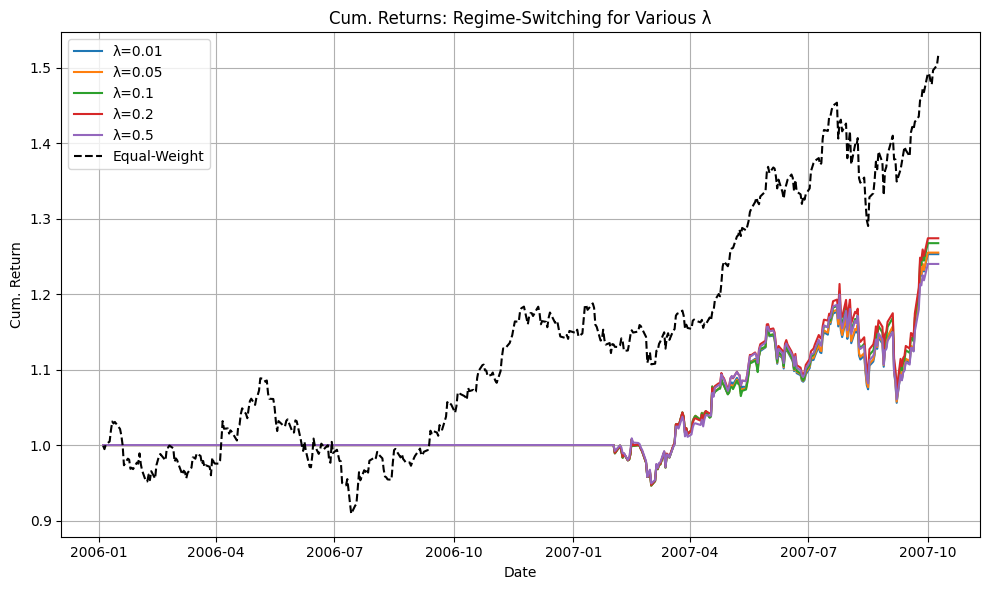

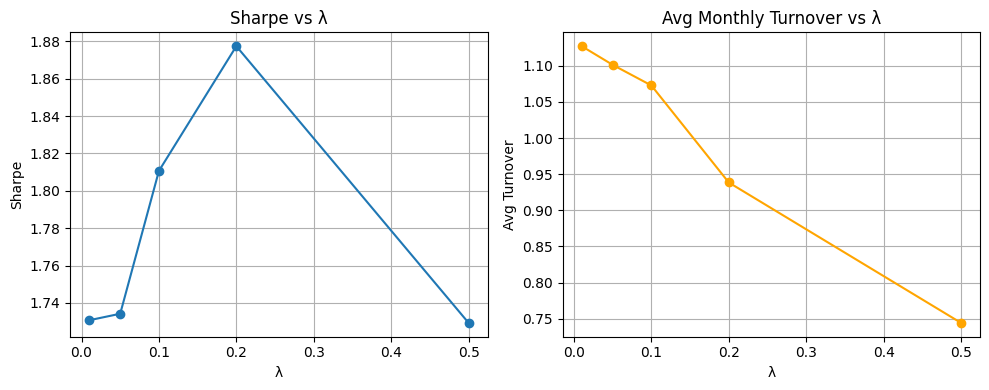

λ tuning results:
         AnnRet_Reg  AnnVol_Reg  Sharpe_Reg  AvgTurn
lambda                                             
0.01        0.3621      0.2092      1.7307   1.1272
0.05        0.3648      0.2104      1.7342   1.1013
0.10        0.3797      0.2097      1.8107   1.0728
0.20        0.3866      0.2059      1.8774   0.9385
0.50        0.3444      0.1991      1.7293   0.7442

2‐Regime vs 3‐Regime (λ=0.1):
               AnnRet_Reg  AnnVol_Reg  Sharpe_Reg  AvgTurn
n_components                                             
2                 0.3797      0.2097      1.8107   1.0728
3                 0.5413      0.2510      2.1561   1.0375


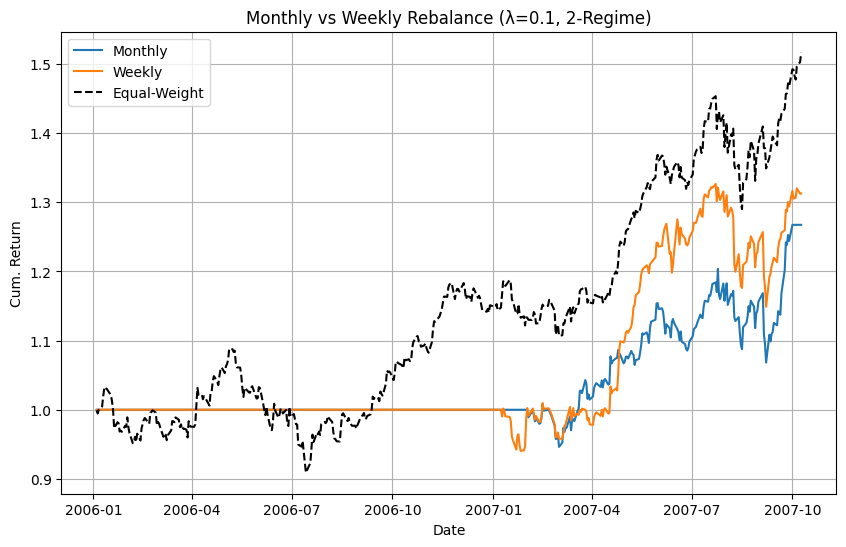


Rebalance Frequency Comparison (λ=0.1, 2‐Regime):
Monthly → AnnRet: 37.97%, AnnVol: 20.97%, Sharpe: 1.81, AvgTurn: 1.0728
Weekly  → AnnRet: 38.53%, AnnVol: 21.17%, Sharpe: 1.82, AvgTurn: 0.6854


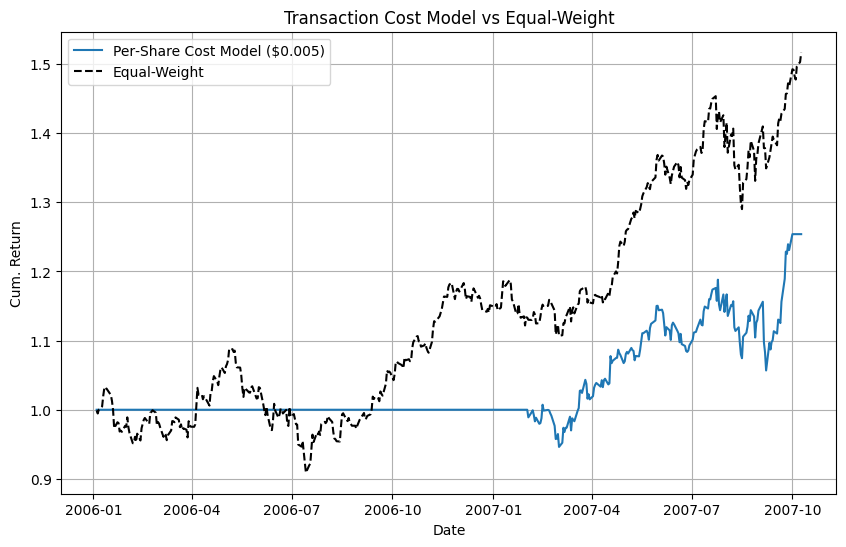


Transaction Cost Model ($0.005 per share):
AnnRet: 36.34%, AnnVol: 20.88%, Sharpe: 1.74, AvgTurn (shares): 0.0336


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta

# ----------------------------------------
# 1. LOAD & PREPROCESS DATA
# ----------------------------------------
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert Date and cast numeric columns
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)
df = df.drop_duplicates(subset=['Date','Name'])

# Pivot to price_data: index=Date, columns=Ticker
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# Select top 20 by avg volume
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

# Keep only dates where all 20 tickers present
price_data = close_prices[top_20].dropna()

# Compute daily returns
returns = price_data.pct_change().dropna(how='all')

# Market proxy: SPY if present else first ticker
market_ticker = 'SPY' if 'SPY' in returns.columns else top_20[0]
market_ret = returns[[market_ticker]]

# ----------------------------------------
# 2. HELPER FUNCTIONS
# ----------------------------------------
def first_trading_of_month(dates_index):
    eval_dates = []
    cur = dates_index[0]
    end = dates_index[-1]
    while cur <= end:
        fo = cur.replace(day=1)
        if fo not in dates_index:
            fo = dates_index[dates_index.get_indexer([fo], method='bfill')[0]]
        eval_dates.append(fo)
        cur = fo + relativedelta(months=1)
    return eval_dates

def first_trading_of_week(dates_index):
    eval_dates = []
    cur = dates_index[0]
    end = dates_index[-1]
    while cur <= end:
        week_start = cur - pd.Timedelta(days=cur.weekday())
        if week_start not in dates_index:
            week_start = dates_index[dates_index.get_indexer([week_start], method='bfill')[0]]
        if not eval_dates or week_start != eval_dates[-1]:
            eval_dates.append(week_start)
        cur = week_start + pd.Timedelta(weeks=1)
    return eval_dates

def negative_sharpe_with_turnover(w, mu, cov, w_prev, lam):
    w = np.clip(w, 0, 1)
    if w.sum() <= 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w.sum()
    port_ret = w.dot(mu)
    port_vol = np.sqrt(w.dot(cov).dot(w))
    sharpe = port_ret / port_vol if port_vol > 0 else 0.0
    turnover = np.sum(np.abs(w - w_prev))
    return -sharpe + lam * turnover

def negative_sharpe_with_cost(w, mu, cov, w_prev, prices_at_reb, cost_per_share):
    w = np.clip(w, 0, 1)
    if w.sum() <= 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w.sum()
    port_ret = w.dot(mu)
    port_vol = np.sqrt(w.dot(cov).dot(w))
    sharpe = port_ret / port_vol if port_vol > 0 else 0.0
    shares_traded = np.abs(w - w_prev) / prices_at_reb
    total_cost = cost_per_share * shares_traded.sum()
    return -sharpe + total_cost

def backtest_regime_switch(
    lam=0.1,
    n_components=2,
    rebalance_func=first_trading_of_month,
    cost_model=None,
    cost_param=None
):
    lookback = 252
    eval_dates = rebalance_func(returns.index)
    n_assets = len(top_20)
    w_prev = np.ones(n_assets) / n_assets

    reb_info = []
    port_daily = []
    turnover_list = []

    for i in range(len(eval_dates)-1):
        reb_date = eval_dates[i]
        next_reb = eval_dates[i+1]

        if reb_date not in returns.index:
            reb_date = returns.index[returns.index.get_indexer([reb_date], method='bfill')[0]]
        idx_reb = returns.index.get_loc(reb_date)
        if idx_reb < lookback:
            continue

        win_rets = returns.iloc[idx_reb-lookback+1:idx_reb+1][top_20]
        win_mkt  = market_ret.iloc[idx_reb-lookback+1:idx_reb+1]

        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(win_mkt.values.reshape(-1,1))

        r_today = market_ret.loc[reb_date].values.reshape(-1,1)
        reg_today = int(gmm.predict(r_today)[0])

        regs_win = gmm.predict(win_mkt.values.reshape(-1,1))
        wr = win_rets.copy()
        wr['Regime'] = regs_win

        rets0 = wr[wr['Regime']==0].drop(columns='Regime')
        mu0  = rets0.mean().values * 252
        cov0 = rets0.cov().values * 252

        if n_components >= 2:
            rets1 = wr[wr['Regime']==1].drop(columns='Regime')
            mu1  = rets1.mean().values * 252
            cov1 = rets1.cov().values * 252
        if n_components == 3:
            rets2 = wr[wr['Regime']==2].drop(columns='Regime')
            mu2  = rets2.mean().values * 252
            cov2 = rets2.cov().values * 252

        if n_components == 2:
            mu_curr = mu0 if reg_today==0 else mu1
            cov_curr = cov0 if reg_today==0 else cov1
        else:
            if reg_today==0:
                mu_curr, cov_curr = mu0, cov0
            elif reg_today==1:
                mu_curr, cov_curr = mu1, cov1
            else:
                mu_curr, cov_curr = mu2, cov2

        if cost_model=='per_share':
            prices_reb = price_data.loc[reb_date, top_20].values
            func = negative_sharpe_with_cost
            args = (mu_curr, cov_curr, w_prev, prices_reb, cost_param)
        else:
            func = negative_sharpe_with_turnover
            args = (mu_curr, cov_curr, w_prev, lam)

        bounds = tuple((0,1) for _ in range(n_assets))
        cons = ({'type':'eq','fun': lambda w: np.sum(w) - 1},)
        res = minimize(func, x0=w_prev.copy(), args=args, method='SLSQP', bounds=bounds, constraints=cons)
        w_opt = np.clip(res.x,0,1)
        if w_opt.sum()<=0:
            w_opt = np.ones(n_assets)/n_assets
        else:
            w_opt /= w_opt.sum()

        if cost_model=='per_share':
            shares = np.abs(w_opt - w_prev) / price_data.loc[reb_date, top_20].values
            turnover_list.append(shares.sum())
        else:
            turnover_list.append(np.sum(np.abs(w_opt - w_prev)))

        reb_info.append((reb_date, w_opt.copy(), reg_today))
        w_prev = w_opt.copy()

        slice_rets = returns.loc[reb_date:next_reb].iloc[1:]
        for date, row in slice_rets[top_20].iterrows():
            port_daily.append((date, row.values.dot(w_opt)))

    if port_daily:
        dates_p, vals_p = zip(*port_daily)
        port_series = pd.Series(data=vals_p, index=pd.DatetimeIndex(dates_p))
    else:
        port_series = pd.Series(dtype=float)

    w_eq = np.ones(n_assets)/n_assets
    eq_series = pd.Series(data=(returns[top_20].values @ w_eq), index=returns.index)

    cum_eq = (1+eq_series).cumprod()
    cum_reg = (1+port_series).cumprod().reindex(returns.index, method='ffill').fillna(1)

    def stats(s):
        m = s.mean()
        sd = s.std()
        ar = m*252
        av = sd*np.sqrt(252)
        sh = ar/av if av>0 else np.nan
        return ar, av, sh

    perf_reg = stats(port_series)
    perf_eqn = stats(eq_series)
    avg_turn = np.nanmean(turnover_list) if turnover_list else np.nan

    return cum_reg, cum_eq, perf_reg, perf_eqn, avg_turn

# ----------------------------------------
# 3. TUNE λ: λ ∈ [0.01, 0.05, 0.1, 0.2, 0.5]
# ----------------------------------------
lambda_list = [0.01, 0.05, 0.1, 0.2, 0.5]
results_lambda = []

plt.figure(figsize=(10,6))
for lam in lambda_list:
    cum_reg, cum_eq, perf_reg, perf_eq, avg_turn = backtest_regime_switch(
        lam=lam,
        n_components=2,
        rebalance_func=first_trading_of_month,
        cost_model=None
    )
    results_lambda.append({
        'lambda': lam,
        'AnnRet_Reg': perf_reg[0],
        'AnnVol_Reg': perf_reg[1],
        'Sharpe_Reg': perf_reg[2],
        'AvgTurn': avg_turn
    })
    plt.plot(cum_reg, label=f"λ={lam}")
plt.plot(cum_eq, '--', color='black', label="Equal-Weight")
plt.title("Cum. Returns: Regime-Switching for Various λ")
plt.xlabel("Date")
plt.ylabel("Cum. Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_lambda = pd.DataFrame(results_lambda).set_index('lambda')
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(df_lambda.index, df_lambda['Sharpe_Reg'], marker='o')
plt.title("Sharpe vs λ")
plt.xlabel("λ")
plt.ylabel("Sharpe")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(df_lambda.index, df_lambda['AvgTurn'], marker='o', color='orange')
plt.title("Avg Monthly Turnover vs λ")
plt.xlabel("λ")
plt.ylabel("Avg Turnover")
plt.grid(True)

plt.tight_layout()
plt.show()

print("λ tuning results:\n", df_lambda.round(4))

# ----------------------------------------
# 4. COMPARE 2‐REGIME vs 3‐REGIME (λ=0.1)
# ----------------------------------------
regime_comparison = []
lam_fixed = 0.1
for n_comp in [2, 3]:
    cum_reg, cum_eq, perf_reg, perf_eq, avg_turn = backtest_regime_switch(
        lam=lam_fixed,
        n_components=n_comp,
        rebalance_func=first_trading_of_month,
        cost_model=None
    )
    regime_comparison.append({
        'n_components': n_comp,
        'AnnRet_Reg': perf_reg[0],
        'AnnVol_Reg': perf_reg[1],
        'Sharpe_Reg': perf_reg[2],
        'AvgTurn': avg_turn
    })

df_regime = pd.DataFrame(regime_comparison).set_index('n_components')
print("\n2‐Regime vs 3‐Regime (λ=0.1):\n", df_regime.round(4))

# ----------------------------------------
# 5. WEEKLY vs MONTHLY REBALANCE (λ=0.1, 2‐regime)
# ----------------------------------------
cum_mo, _, perf_mo, _, avg_mo = backtest_regime_switch(
    lam=lam_fixed, n_components=2, rebalance_func=first_trading_of_month, cost_model=None
)
cum_wk, _, perf_wk, _, avg_wk = backtest_regime_switch(
    lam=lam_fixed, n_components=2, rebalance_func=first_trading_of_week, cost_model=None
)

plt.figure(figsize=(10,6))
plt.plot(cum_mo, label="Monthly")
plt.plot(cum_wk, label="Weekly")
plt.plot(cum_eq, '--', color='black', label="Equal-Weight")
plt.title("Monthly vs Weekly Rebalance (λ=0.1, 2‐Regime)")
plt.xlabel("Date")
plt.ylabel("Cum. Return")
plt.legend()
plt.grid(True)
plt.show()

print("\nRebalance Frequency Comparison (λ=0.1, 2‐Regime):")
print(f"Monthly → AnnRet: {perf_mo[0]:.2%}, AnnVol: {perf_mo[1]:.2%}, Sharpe: {perf_mo[2]:.2f}, AvgTurn: {avg_mo:.4f}")
print(f"Weekly  → AnnRet: {perf_wk[0]:.2%}, AnnVol: {perf_wk[1]:.2%}, Sharpe: {perf_wk[2]:.2f}, AvgTurn: {avg_wk:.4f}")

# ----------------------------------------
# 6. TRANSACTION COST MODEL ($0.005 per share)
# ----------------------------------------
cost_per_share = 0.005
cum_cost, _, perf_cost, _, avg_cost = backtest_regime_switch(
    lam=0.0,
    n_components=2,
    rebalance_func=first_trading_of_month,
    cost_model='per_share',
    cost_param=cost_per_share
)

plt.figure(figsize=(10,6))
plt.plot(cum_cost, label="Per‐Share Cost Model ($0.005)")
plt.plot(cum_eq, '--', color='black', label="Equal-Weight")
plt.title("Transaction Cost Model vs Equal‐Weight")
plt.xlabel("Date")
plt.ylabel("Cum. Return")
plt.legend()
plt.grid(True)
plt.show()

print("\nTransaction Cost Model ($0.005 per share):")
print(f"AnnRet: {perf_cost[0]:.2%}, AnnVol: {perf_cost[1]:.2%}, Sharpe: {perf_cost[2]:.2f}, AvgTurn (shares): {avg_cost:.4f}")


#Conditional Value at Risk (CVaR) Optimization
Instead of classic mean‐variance (which targets variance), CVaR (also called Expected Shortfall) directly minimizes tail‐risk. In other words, we choose weights
𝑤
w that minimize the average of the worst
𝛼
α% losses, subject to a full‐investment and no‐shorting constraint. This is especially useful if you care more about extreme‐downside outcomes than about ordinary fluctuations.

1. What is CVaR?
For a given loss distribution
𝐿
(
𝑤
)
=
−

𝑤
⊤
𝑟
L(w)=−w
⊤
 r (where
𝑟
r is the vector of random returns), the Value at Risk (VaR) at level
𝛼
α is the
𝛼
α-quantile of the loss:

VaR
𝛼
(
𝑤
)

=

inf
⁡
{

ℓ
:
𝑃
(
𝐿
(
𝑤
)
≤
ℓ
)
≥
𝛼
}
.
VaR
α
​
 (w)=inf{ℓ:P(L(w)≤ℓ)≥α}.
The CVaR (Conditional VaR), also called Expected Shortfall, is the average loss beyond that quantile:

CVaR
𝛼
(
𝑤
)

=

𝐸
[
𝐿
(
𝑤
)
∣
𝐿
(
𝑤
)
≥
VaR
𝛼
(
𝑤
)
]
.
CVaR
α
​
 (w)=E[L(w)∣L(w)≥VaR
α
​
 (w)].
In practice, with historical returns, we can formulate CVaR minimization as a linear program (Rockafellar‐Uryasev formulation).

2. Why CVaR?
It directly controls tail‐risk (the worst
𝛼
α% scenarios).

It often yields portfolios that look different from MV: heavily underweight very‐volatile assets that occasionally crash.

You can trade off return vs. CVaR by introducing a penalty or constraint on CVaR.

Below, we’ll show how to minimize CVaR subject to a target return
𝑅
target
R
target
​
 . If you want a pure “minimum‐CVaR” with no return constraint, simply remove the return constraint and minimize CVaR alone.

3. Formulation (Historical Scenario CVaR)
Let:

𝑁
N = number of assets (we’ll use our top 20 tickers).

𝑇
T = number of historical daily scenarios (returns). Denote by
𝑟
𝑡
∈
𝑅
𝑁
r
t
​
 ∈R
N
  the vector of realized returns on day
𝑡
t.

𝑤
∈
𝑅
𝑁
w∈R
N
  = portfolio weights (we require
∑
𝑖
𝑤
𝑖
=
1
∑
i
​
 w
i
​
 =1,
𝑤
𝑖
≥
0
w
i
​
 ≥0).

Choose a CVaR confidence level
𝛼
α (e.g. 95%, so
𝛼
=
0.95
α=0.95).

Define the loss on day
𝑡
t as
𝐿
𝑡
(
𝑤
)
=
−
𝑤
⊤
𝑟
𝑡
L
t
​
 (w)=−w
⊤
 r
t
​
 .

Using Rockafellar‐Uryasev, we introduce:

A scalar variable
𝜈
ν approximating VaR
𝛼
α
​
 .

Auxiliary slack variables
𝜉
𝑡
≥
0
ξ
t
​
 ≥0 for each scenario
𝑡
t.

Then the CVaR minimization problem is:

min
⁡
𝑤
,

𝜈
,

𝜉


𝜈

+

1
(
1
−
𝛼
)

𝑇
∑
𝑡
=
1
𝑇
𝜉
𝑡
,
subject to:
𝜉
𝑡

≥

𝐿
𝑡
(
𝑤
)
−
𝜈
,
∀

𝑡
=
1
,
…
,
𝑇
,
𝜉
𝑡

≥

0
,
∀

𝑡
,
∑
𝑖
=
1
𝑁
𝑤
𝑖

=

1
,
𝑤
𝑖

≥

0
,
∀

𝑖
,
(optional)
𝑤
⊤
𝑟
ˉ

≥

𝑅
target
,
​
  
w,ν,ξ
min
​
 ν+
(1−α)T
1
​
  
t=1
∑
T
​
 ξ
t
​
 ,
subject to:
ξ
t
​
 ≥L
t
​
 (w)−ν,∀t=1,…,T,
ξ
t
​
 ≥0,∀t,
i=1
∑
N
​
 w
i
​
 =1,
w
i
​
 ≥0,∀i,
(optional) w
⊤
  
r
ˉ
 ≥R
target
​
 ,
​

where
𝑟
ˉ
=
1
𝑇
∑
𝑡
=
1
𝑇
𝑟
𝑡
r
ˉ
 =
T
1
​
 ∑
t=1
T
​
 r
t
​
  is the historical mean (used if you impose a minimum expected return).

The first constraint enforces
𝜉
𝑡
≥
𝐿
𝑡
−
𝜈
ξ
t
​
 ≥L
t
​
 −ν. If
𝐿
𝑡
(
𝑤
)
≤
𝜈
L
t
​
 (w)≤ν, then
𝜉
𝑡
ξ
t
​
  can be zero. If
𝐿
𝑡
(
𝑤
)
>
𝜈
L
t
​
 (w)>ν, then
𝜉
𝑡
=
𝐿
𝑡
−
𝜈
ξ
t
​
 =L
t
​
 −ν.

(
1
−
𝛼
)

𝑇
(1−α)T is the number of “tail” points (e.g. if
𝛼
=
0.95
α=0.95, then
1
−
𝛼
=
0.05
1−α=0.05, so the worst 5% of
𝑇
T days).

Minimizing
𝜈
+
1
(
1
−
𝛼
)
𝑇
∑
𝜉
𝑡
ν+
(1−α)T
1
​
 ∑ξ
t
​
  exactly corresponds to minimizing CVaR
𝛼
(
𝑤
)
α
​
 (w).

In [ ]:
!pip install cvxpy


Using 444 historical daily scenarios and 4 assets for CVaR optimization.
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 05 02:00:47 PM: Your problem has 449 variables, 893 constraints, and 0 parameters.
(CVXPY) Jun 05 02:00:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 05 02:00:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 05 02:00:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 05 02:00:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
----------------------------------------------------------------------------

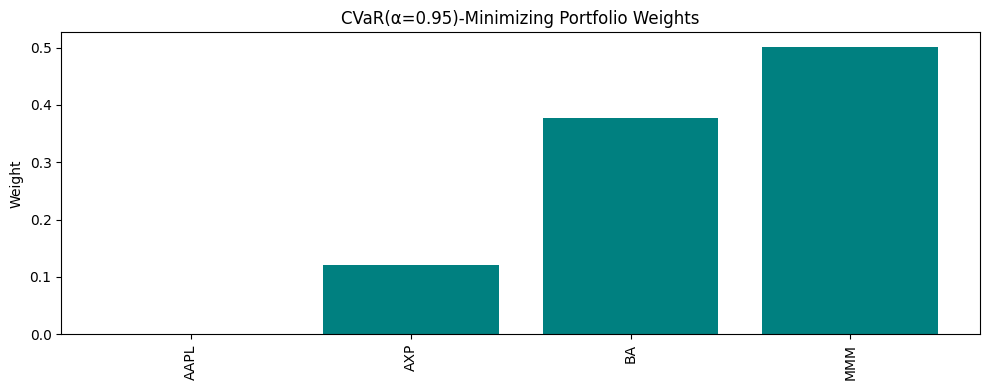

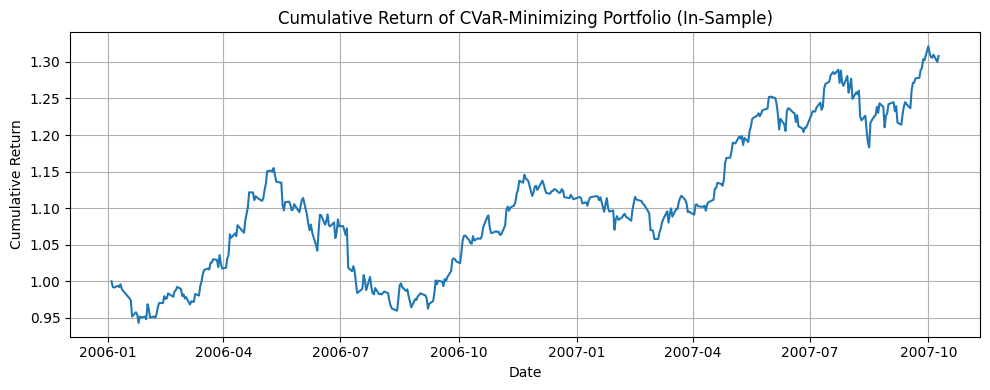


In‐Sample CVaR Portfolio Performance:
  Annualized Return: 16.25%
  Annualized Volatility: 14.20%
  Sharpe Ratio: 1.14


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# 1. LOAD & PREPROCESS DATA (same as before) ------------------------

file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)
df = df.drop_duplicates(subset=['Date','Name'])

close_prices = df.pivot(index='Date', columns='Name', values='Close')

mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

price_data = close_prices[top_20].dropna()
# Use all available dates for scenario simulations:
returns = price_data.pct_change().dropna(how='all').values  # shape: (T, 20)

T, N = returns.shape
print(f"Using {T} historical daily scenarios and {N} assets for CVaR optimization.")

# Historical mean for a return constraint (optional)
mean_hist = returns.mean(axis=0)  # shape (20,)

# 2. SET UP CVaR PROBLEM (α = 0.95) ---------------------------------------

alpha = 0.95

# Decision variables:
w   = cp.Variable(N)              # portfolio weights w_i ≥ 0, sum = 1
nu  = cp.Variable()               # VaR approximation
xi  = cp.Variable(T)              # slack variables for each scenario

# Build loss vector: negative portfolio return per day
# In cvxpy, we can write r_i * w as a vector multiply
# Let R be the matrix of historical returns (T×N)
R = returns  # each row t is r_t vector

# Define constraints
constraints = []

# 2.1: ξ_t ≥ -w^⊤ r_t - ν,   for t=1...T
for t in range(T):
    constraints.append(xi[t] >= -R[t, :] @ w - nu)

# 2.2: ξ_t ≥ 0
constraints += [xi >= 0]

# 2.3: full investment ∑ w_i = 1, and w_i ≥ 0
constraints += [cp.sum(w) == 1, w >= 0]

# 2.4: (Optional) impose that expected portfolio return ≥ R_target
R_target = 0.10  # e.g. target 10% annual. Convert daily: approx 0.10/252
# If you want this constraint, un-comment:
#constraints.append(w @ mean_hist >= R_target/252)

# 3. OBJECTIVE: minimize ν + (1 / ((1-α)*T)) * ∑ ξ_t
obj = nu + (1/((1 - alpha) * T)) * cp.sum(xi)

prob = cp.Problem(cp.Minimize(obj), constraints)

# 4. SOLVE
prob.solve(solver=cp.SCS, verbose=True)  # you can also try 'ECOS' or 'OSQP'

print("\nStatus:", prob.status)
print(f"Optimal CVaR_{alpha:.2f}:", prob.value)

w_opt = w.value
print("\nOptimal weights (CVaR-minimizing):")
for i, ticker in enumerate(top_20):
    print(f"  {ticker}: {w_opt[i]:.4f}")

# 5. PLOT WEIGHTS AS BAR CHART
plt.figure(figsize=(10,4))
plt.bar(top_20, w_opt, color='teal')
plt.xticks(rotation=90)
plt.ylabel("Weight")
plt.title(f"CVaR(α={alpha:.2f})-Minimizing Portfolio Weights")
plt.tight_layout()
plt.show()

# 6. BACKTEST THE CVaR PORTFOLIO (OUT‐OF‐SAMPLE SIMULATION)
# For simplicity, we’ll do an “in‐sample” historical backtest: compute daily P&L using w_opt
# On each day t, portfolio return = r_t · w_opt

port_daily = returns @ w_opt  # shape (T,)
# Cumulative return series
cum = np.cumprod(1 + port_daily)

plt.figure(figsize=(10,4))
plt.plot(price_data.index[1:], cum, label="CVaR Portfolio")
plt.title("Cumulative Return of CVaR-Minimizing Portfolio (In‐Sample)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. PERFORMANCE METRICS
annual_ret = np.mean(port_daily) * 252
annual_vol = np.std(port_daily) * np.sqrt(252)
sharpe     = annual_ret / annual_vol if annual_vol>0 else np.nan

print(f"\nIn‐Sample CVaR Portfolio Performance:")
print(f"  Annualized Return: {annual_ret:.2%}")
print(f"  Annualized Volatility: {annual_vol:.2%}")
print(f"  Sharpe Ratio: {sharpe:.2f}")


#Out‐of‐Sample Walk‐Forward for both CVaR‐minimization and classic mean‐variance (MV) portfolios, and compares them to a simple equal‐weight (EW) benchmark.

Using 444 days × 4 tickers (top 20 by volume).
Test period begins on: 2007-03-30
Total valid rebalance months with ≥252-day lookback: 9
Out‐of‐Sample portfolio dates count: 139 from 2007-03-30 to 2007-10-09


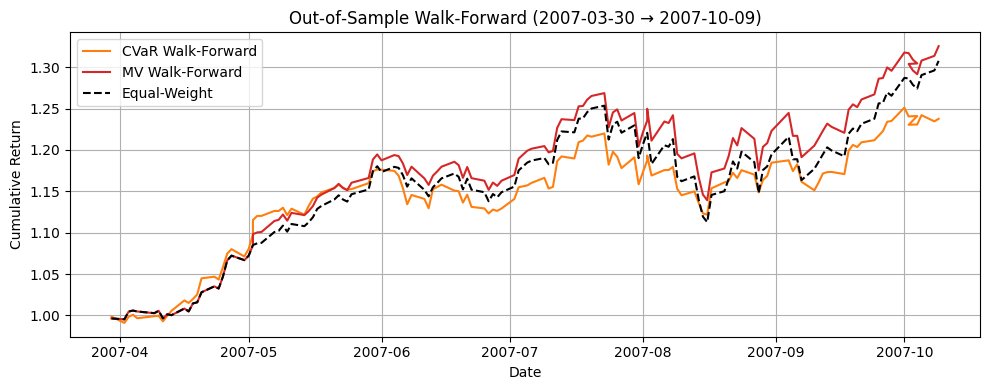


Performance (Out‐of‐Sample):
 CVaR Walk‐Forward → Ann Return: 39.86%, Volatility: 15.33%, Sharpe: 2.60
 MV Walk‐Forward   → Ann Return: 52.80%, Volatility: 18.18%, Sharpe: 2.90
 Equal‐Weight      → Ann Return: 52.20%, Volatility: 18.37%, Sharpe: 2.84


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, linprog
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. LOAD & PREPROCESS DATA
# ----------------------------------------
file_path = '/content/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(file_path)

# Convert Date to datetime and cast prices/volumes to float
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].astype(float)
df['Volume'] = df['Volume'].astype(float)

# Drop exact duplicates
df = df.drop_duplicates(subset=['Date','Name'])

# Pivot so each column is "Close price of that ticker"
close_prices = df.pivot(index='Date', columns='Name', values='Close')

# Choose top 20 tickers by average Volume (highest liquidity)
mean_vol = df.groupby('Name')['Volume'].mean().sort_values(ascending=False)
top_20 = mean_vol.head(20).index.tolist()

# Restrict to dates where *all* 20 tickers have data
price_data = close_prices[top_20].dropna()

# Compute daily returns (percentage change)
returns_df = price_data.pct_change().dropna(how='all')
dates = returns_df.index
rets = returns_df.values
T, N = rets.shape

print(f"Using {T} days × {N} tickers (top 20 by volume).")

# ----------------------------------------
# 2. DEFINE TEST START & REBALANCE DATES
# ----------------------------------------
# We'll set test_start = the date at index 70% through the sample
test_start_index = int(0.7 * T)
test_start = dates[test_start_index]
print("Test period begins on:", test_start.date())

# Build a list of "first trading day of each calendar month" in the data
rebalance_dates = []
cur = dates[0]
end = dates[-1]
while cur <= end:
    first_of_month = cur.replace(day=1)
    if first_of_month not in dates:
        # Move to the next available trading date if needed
        pos = dates.get_indexer([first_of_month], method='bfill')[0]
        first_of_month = dates[pos]
    rebalance_dates.append(first_of_month)
    cur = first_of_month + relativedelta(months=1)

# Now filter to those "rebalance_dates" where we have at least 252 days of history
# (so we can build a 1-yr lookback) AND there *is* a next-month trading date
lookback = 252
reb_valid = []
for rd in rebalance_dates:
    if rd not in dates:
        continue
    idx_rd = dates.get_loc(rd)
    if idx_rd < lookback:
        # Not enough lookback history yet
        continue
    # Ensure "next month" also exists in dates
    next_month = rd + relativedelta(months=1)
    if next_month not in dates:
        pos2 = dates.get_indexer([next_month], method='bfill')[0]
        next_month = dates[pos2]
    if next_month <= end:
        reb_valid.append(rd)

print(f"Total valid rebalance months with ≥252-day lookback: {len(reb_valid)}")

# ----------------------------------------
# 3. WALK-FORWARD BACKTEST
# ----------------------------------------
alpha = 0.95   # CVaR confidence level
port_ret_cvar = []
port_ret_mv   = []
port_dates    = []

# For each valid "rebalance date" (first trading day of month):
for rd in reb_valid:
    idx_rd = dates.get_loc(rd)
    # 3.1. Build the 252-day training window ending on rd
    start_idx = idx_rd - lookback + 1
    R_train = rets[start_idx : idx_rd+1, :]  # shape = (252 × 20)
    T_win = R_train.shape[0]  # should be 252

    # ----- 3.2. Solve CVaR LP via scipy.linprog -----
    # Variables x = [w_0..w_{19},  ν,  ξ_0..ξ_{T_win-1}]  → total nvar = 20 + 1 + 252
    nvar = N + 1 + T_win
    c = np.zeros(nvar)
    c[N] = 1  # coefficient for ν
    c[N+1:] = 1.0 / ((1 - alpha) * T_win)  # coefficients for each ξ_t

    # Build A_ub and b_ub for "for each t:  ξ_t ≥ - wᵀ r_t - ν"
    # →   −r_tᵀ w  − ν  − ξ_t   ≤ 0
    A_ub = np.zeros((T_win, nvar))
    b_ub = np.zeros(T_win)
    for t in range(T_win):
        A_ub[t, :N]          = -R_train[t, :]
        A_ub[t, N]           = -1         # for ν
        A_ub[t, N + 1 + t]   = -1         # for ξ_t

    # Equality: sum_i w_i = 1
    A_eq = np.zeros((1, nvar))
    A_eq[0, :N] = 1
    b_eq = np.array([1.0])

    # Bounds: w_i ≥ 0;  ν is free;  ξ_t ≥ 0
    bounds = [(0, None)] * N + [(None, None)] + [(0, None)] * T_win

    # Solve the LP with SciPy's HiGHS solver
    res_lp = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                     bounds=bounds, method='highs')
    if res_lp.success:
        x = res_lp.x
        w_cvar = x[:N]
        w_cvar = np.clip(w_cvar, 0, None)
        if w_cvar.sum() > 0:
            w_cvar = w_cvar / w_cvar.sum()
        else:
            w_cvar = np.ones(N) / N
    else:
        w_cvar = np.ones(N) / N

    # ----- 3.3. Solve classic Minimum‐Variance (MV) via SciPy minimize -----
    mean_train = R_train.mean(axis=0)                   # length 20
    cov_train = np.cov(R_train, rowvar=False)           # 20×20
    def mv_obj(wm):
        wm_clipped = np.clip(wm, 0, 1)
        if wm_clipped.sum() == 0:
            wm_norm = np.ones_like(wm_clipped) / len(wm_clipped)
        else:
            wm_norm = wm_clipped / wm_clipped.sum()
        return wm_norm.T @ cov_train @ wm_norm

    cons_mv = ({'type':'eq', 'fun': lambda wm: np.sum(wm) - 1},)
    bnds_mv = tuple((0, 1) for _ in range(N))
    res_mv = minimize(mv_obj, x0=np.ones(N)/N, method='SLSQP',
                      bounds=bnds_mv, constraints=cons_mv)
    if res_mv.success:
        w_mv = np.clip(res_mv.x, 0, None)
        if w_mv.sum() > 0:
            w_mv = w_mv / w_mv.sum()
        else:
            w_mv = np.ones(N)/N
    else:
        w_mv = np.ones(N)/N

    # ----- 3.4. Apply both w_cvar and w_mv from rd+1 through next_month -----
    next_month = rd + relativedelta(months=1)
    if next_month not in dates:
        pos2 = dates.get_indexer([next_month], method='bfill')[0]
        next_month = dates[pos2]
    i_rd   = dates.get_loc(rd)
    i_next = dates.get_indexer([next_month], method='bfill')[0]
    slice_dates = dates[i_rd+1 : i_next+1]

    for dt in slice_dates:
        if dt < test_start:
            continue
        i_date = dates.get_loc(dt)
        daily_ret = rets[i_date, :]
        port_ret_cvar.append(daily_ret.dot(w_cvar))
        port_ret_mv.append(daily_ret.dot(w_mv))
        port_dates.append(dt)

# Convert to pandas Series for ease of use
port_dates = pd.DatetimeIndex(port_dates)
print("Out‐of‐Sample portfolio dates count:", len(port_dates),
      "from", port_dates.min().date(), "to", port_dates.max().date())

ret_cvar = pd.Series(port_ret_cvar, index=port_dates)
ret_mv   = pd.Series(port_ret_mv,   index=port_dates)

# Build an Equal‐Weight (EW) series over the same out‐of‐sample dates
mask = dates >= test_start
ew_series = pd.Series(
    data=(rets[mask, :] @ (np.ones(N) / N)),
    index=dates[mask]
)

# ----------------------------------------
# 4. PLOT CUMULATIVE RETURNS
# ----------------------------------------
cum_cvar = (1 + ret_cvar).cumprod()
cum_mv   = (1 + ret_mv).cumprod()
cum_eq   = (1 + ew_series).cumprod()

plt.figure(figsize=(10,4))
plt.plot(cum_cvar, label='CVaR Walk‐Forward', color='tab:orange')
plt.plot(cum_mv,   label='MV Walk‐Forward',   color='tab:red')
plt.plot(cum_eq,   '--', color='black', label='Equal‐Weight')
plt.title(f'Out‐of‐Sample Walk‐Forward ({test_start.date()} → {dates[-1].date()})')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 5. PERFORMANCE METRICS
# ----------------------------------------
def perf_stats(series):
    """Given daily return series, return (annual_return, annual_vol, Sharpe)."""
    mean_d = series.mean()
    std_d  = series.std()
    ann_ret = mean_d * 252
    ann_vol = std_d * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
    return ann_ret, ann_vol, sharpe

perf_cvar = perf_stats(ret_cvar)
perf_mv   = perf_stats(ret_mv)
perf_eq   = perf_stats(ew_series)

print("\nPerformance (Out‐of‐Sample):")
print(f" CVaR Walk‐Forward → "
      f"Ann Return: {perf_cvar[0]:.2%}, "
      f"Volatility: {perf_cvar[1]:.2%}, "
      f"Sharpe: {perf_cvar[2]:.2f}")
print(f" MV Walk‐Forward   → "
      f"Ann Return: {perf_mv[0]:.2%}, "
      f"Volatility: {perf_mv[1]:.2%}, "
      f"Sharpe: {perf_mv[2]:.2f}")
print(f" Equal‐Weight      → "
      f"Ann Return: {perf_eq[0]:.2%}, "
      f"Volatility: {perf_eq[1]:.2%}, "
      f"Sharpe: {perf_eq[2]:.2f}")


#Static Basket (SB):
– At the very first rebalance date after the in‐sample period, select the top 20 tickers by average volume (this is already our universe).
– Assign equal weights to those 20 and hold them (i.e.\ never rebalance again).
– Compare SB’s performance to the other methods.

#Momentum‐Based Dynamic Basket (MB):
– Each month at rebalance, compute each ticker’s trailing 63‐day return (≈3 months).
– Select the top 10 tickers by trailing 63-day return (momentum winners) out of our 20-ticker universe.
– Assign equal weights to those 10 stocks for the upcoming month, then re‐evaluate next month.
– This clearly “moves” the basket over time, distinguishing it from SB.

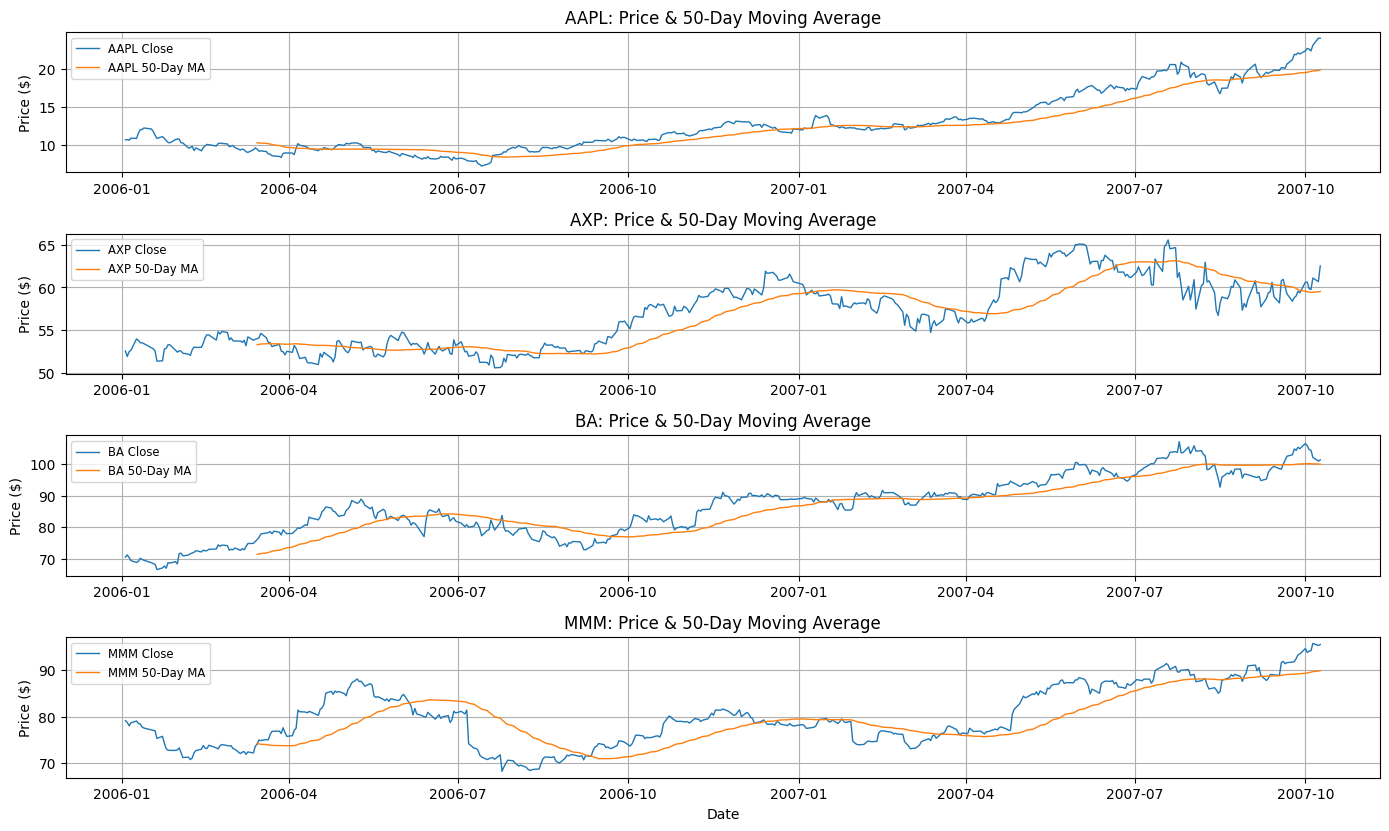

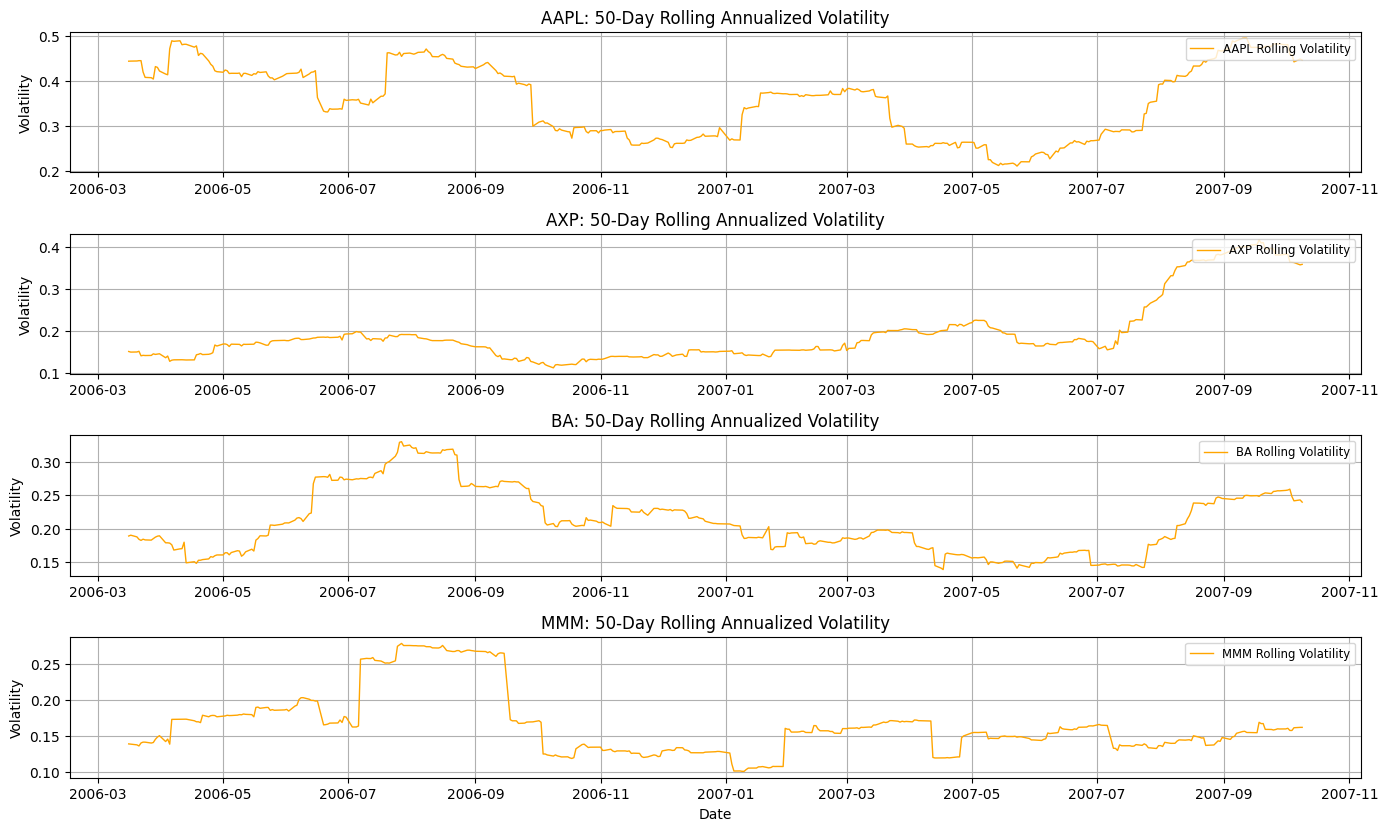

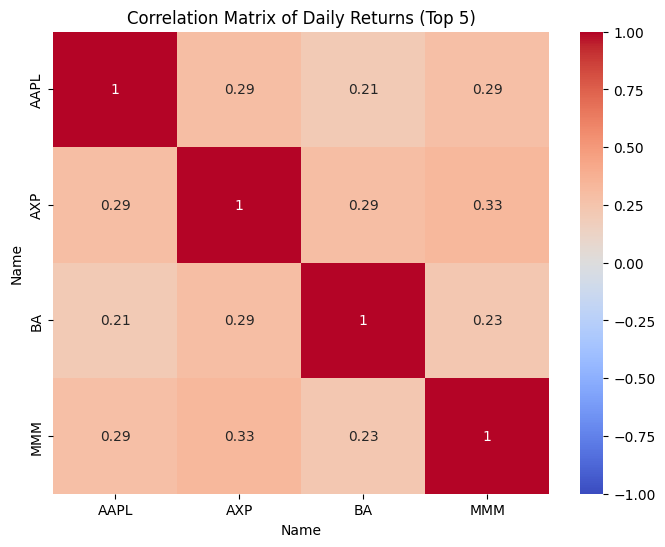

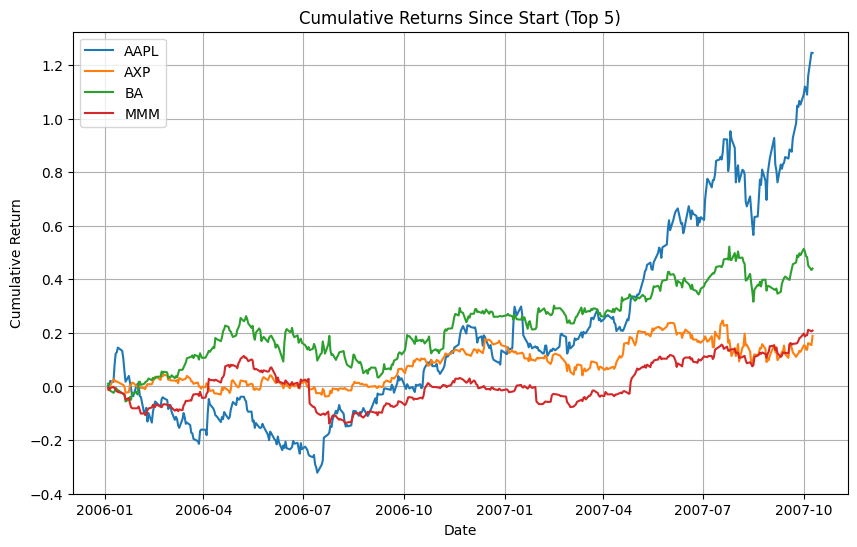


Summary Statistics for Top 5 Tickers:

      Mean Daily Return  Daily Std Dev  Annualized Return  \
AAPL             0.0021         0.0235             0.5281   
AXP              0.0005         0.0132             0.1202   
BA               0.0009         0.0134             0.2297   
MMM              0.0005         0.0107             0.1221   

      Annualized Volatility  Sharpe Ratio (0 RF)  Max Drawdown  
AAPL                 0.3723               1.4186        0.4672  
AXP                  0.2098               0.5731        0.1676  
BA                   0.2132               1.0777        0.2291  
MMM                  0.1697               0.7194        0.2531  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')

# 2. Parse dates (dayfirst=True for DD-MM-YYYY) and pivot to wide closing prices
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Close', 'Name'])  # ensure valid dates and prices
price_df = df.pivot(index='Date', columns='Name', values='Close').dropna(axis=0, how='any')

# 3. Compute daily returns
return_df = price_df.pct_change().dropna()

# 4. Identify top 5 tickers by average volume
vol_df = df.pivot(index='Date', columns='Name', values='Volume').reindex(price_df.index)
avg_vol = vol_df.mean().sort_values(ascending=False)
top5 = avg_vol.index[:5].tolist()

# 5. Subset price and return DataFrames for top 5
prices_top5 = price_df[top5]
returns_top5 = return_df[top5]

# 6. Compute 50-day rolling statistics
rolling_window = 50
ma_top5 = prices_top5.rolling(window=rolling_window).mean()
vol_top5 = returns_top5.rolling(window=rolling_window).std() * np.sqrt(252)  # annualized

# 7a. Plot price vs. 50-day moving average for each of the top 5
plt.figure(figsize=(14, 10))
for i, ticker in enumerate(top5, 1):
    plt.subplot(5, 1, i)
    plt.plot(prices_top5.index, prices_top5[ticker], label=f'{ticker} Close', linewidth=1)
    plt.plot(ma_top5.index, ma_top5[ticker], label=f'{ticker} {rolling_window}-Day MA', linewidth=1)
    plt.title(f'{ticker}: Price & {rolling_window}-Day Moving Average')
    plt.ylabel('Price ($)')
    plt.legend(loc='upper left', fontsize='small')
    plt.grid(True)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 7b. Plot 50-day rolling annualized volatility for each of the top 5
plt.figure(figsize=(14, 10))
for i, ticker in enumerate(top5, 1):
    plt.subplot(5, 1, i)
    plt.plot(vol_top5.index, vol_top5[ticker], label=f'{ticker} Rolling Volatility', color='orange', linewidth=1)
    plt.title(f'{ticker}: {rolling_window}-Day Rolling Annualized Volatility')
    plt.ylabel('Volatility')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 7c. Correlation heatmap of daily returns among top 5
corr_matrix = returns_top5.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Daily Returns (Top 5)')
plt.show()

# 7d. Cumulative returns comparison for top 5
cum_returns = (1 + returns_top5).cumprod() - 1
plt.figure(figsize=(10, 6))
for ticker in top5:
    plt.plot(cum_returns.index, cum_returns[ticker], label=ticker)
plt.title('Cumulative Returns Since Start (Top 5)')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# 8. Summary statistics for top 5
stats_df = pd.DataFrame(index=top5)
stats_df['Mean Daily Return'] = returns_top5.mean()
stats_df['Daily Std Dev'] = returns_top5.std()
stats_df['Annualized Return'] = returns_top5.mean() * 252
stats_df['Annualized Volatility'] = returns_top5.std() * np.sqrt(252)
stats_df['Sharpe Ratio (0 RF)'] = stats_df['Annualized Return'] / stats_df['Annualized Volatility']
stats_df['Max Drawdown'] = cum_returns.apply(lambda x: (x.cummax() - x).max())

# Display the table
print("\nSummary Statistics for Top 5 Tickers:\n")
print(stats_df.round(4))


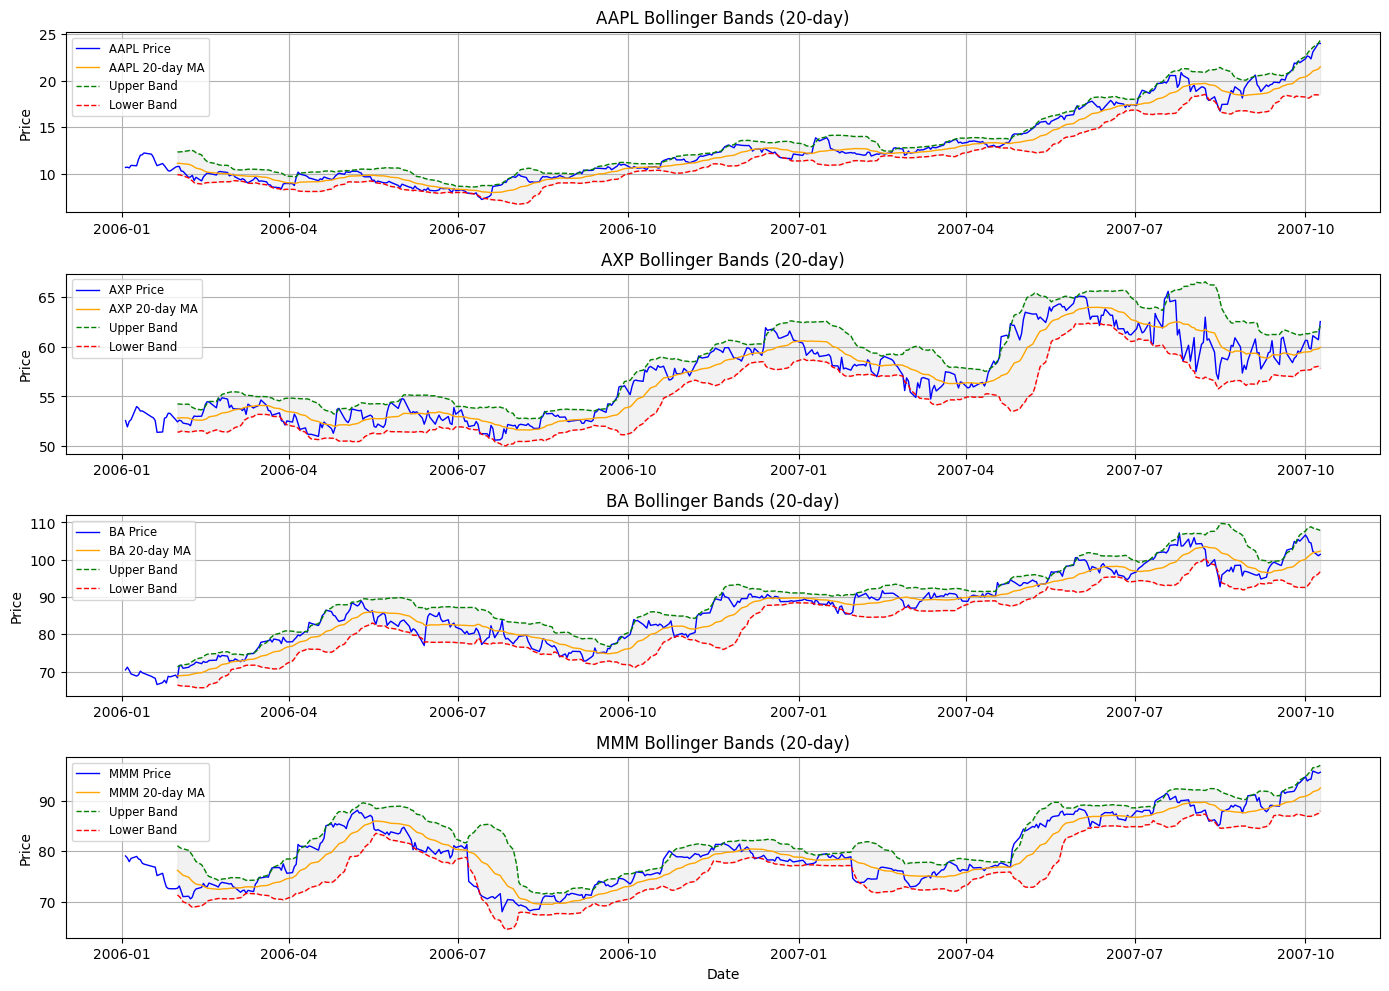

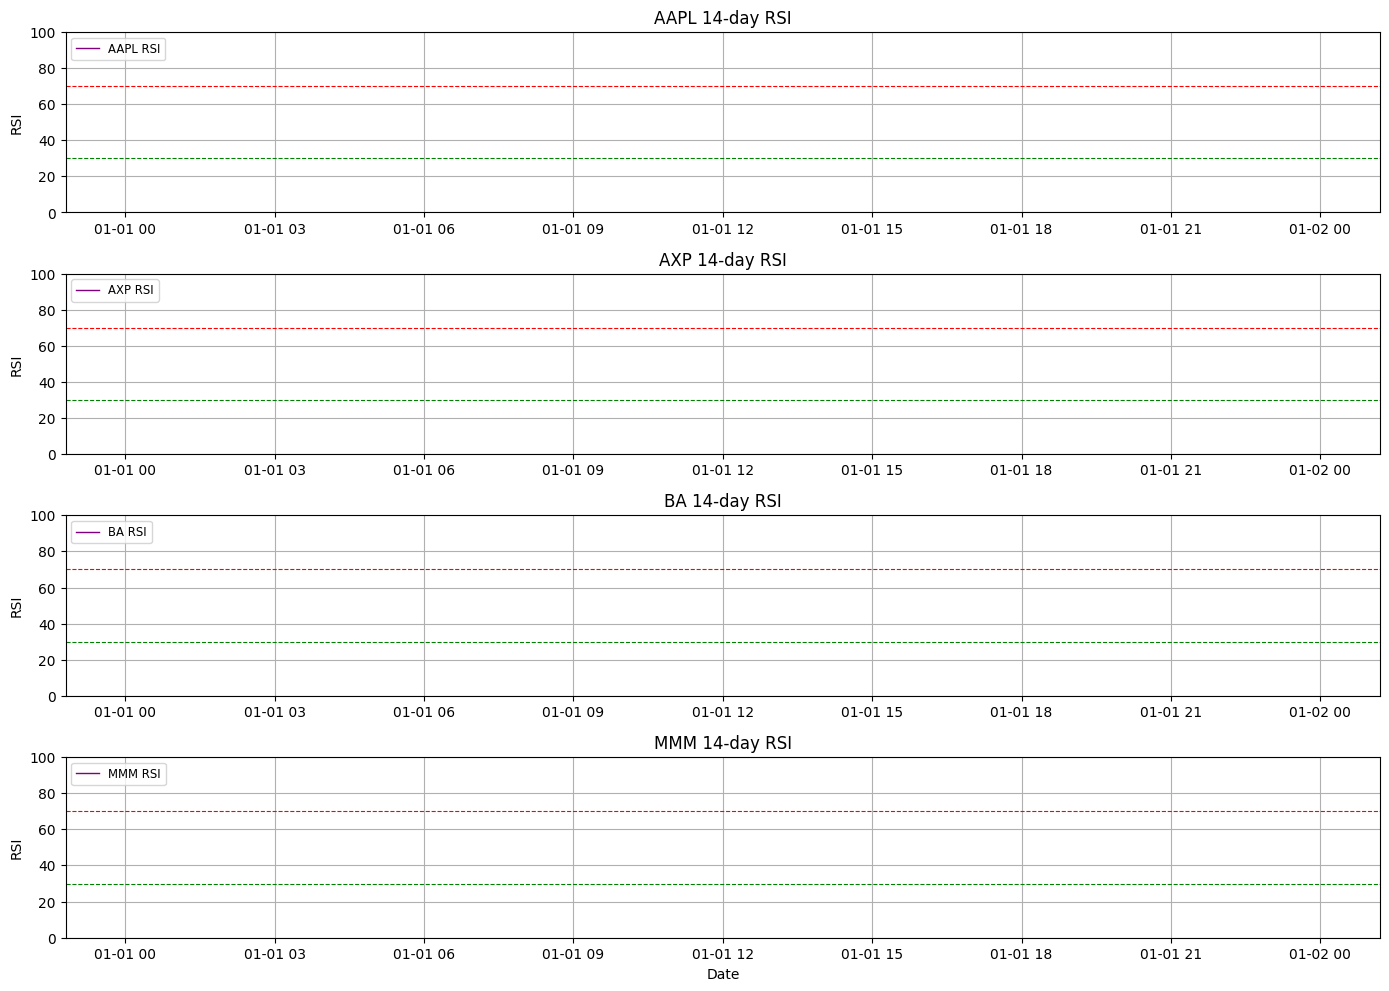

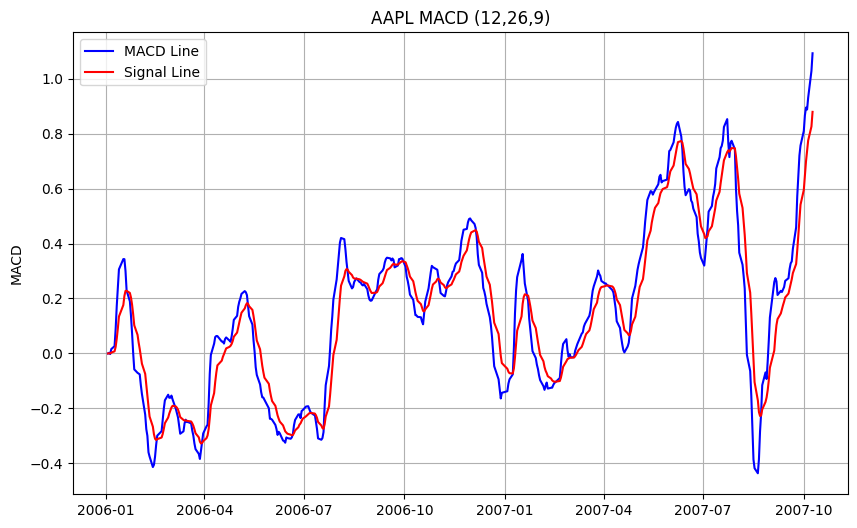

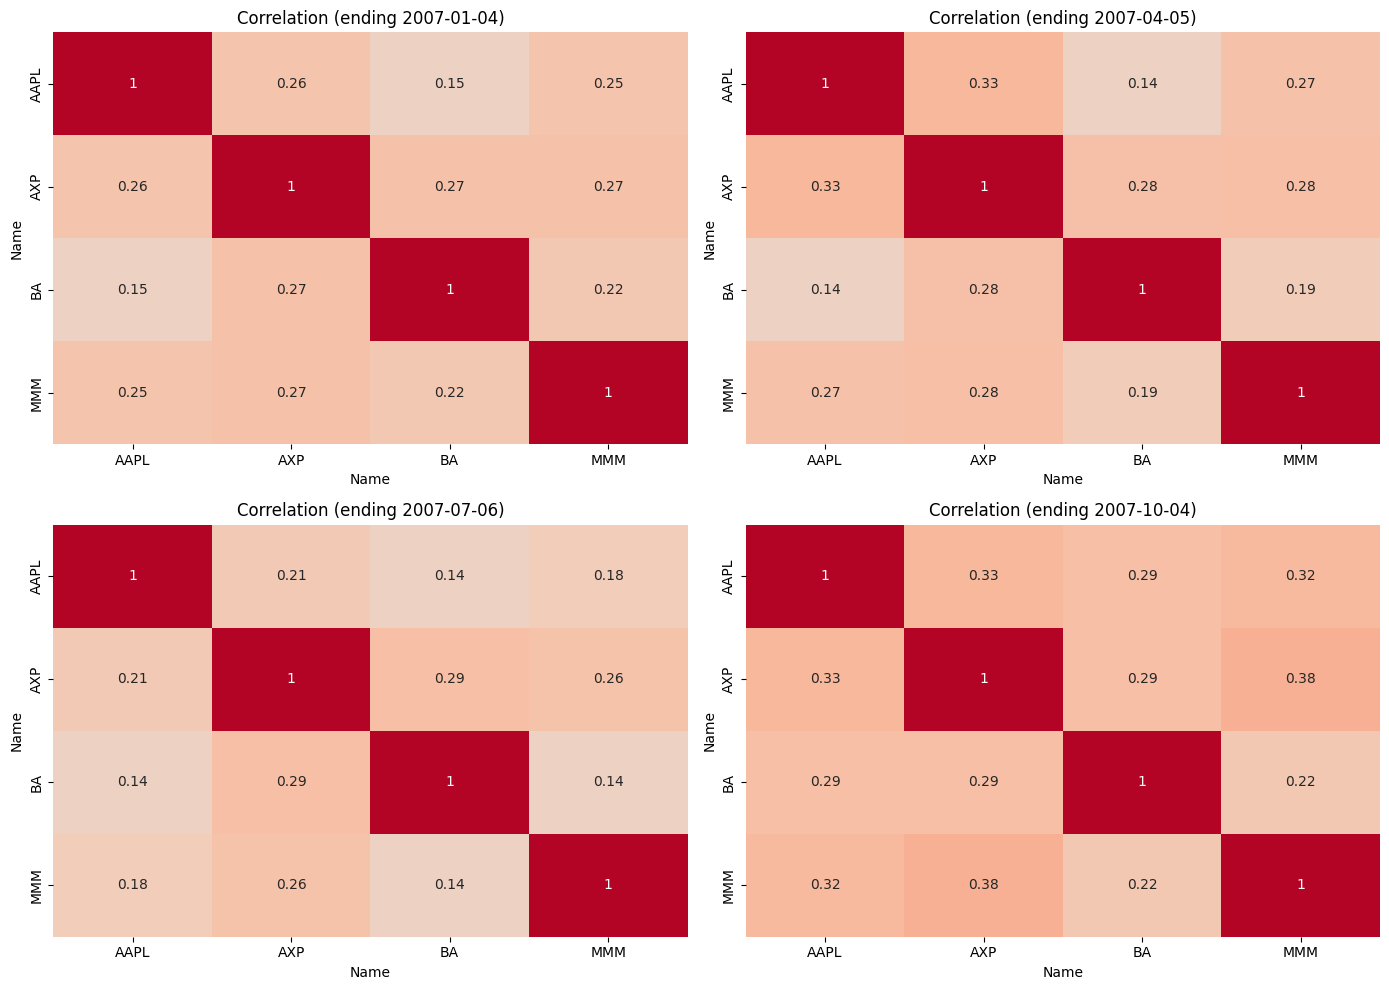

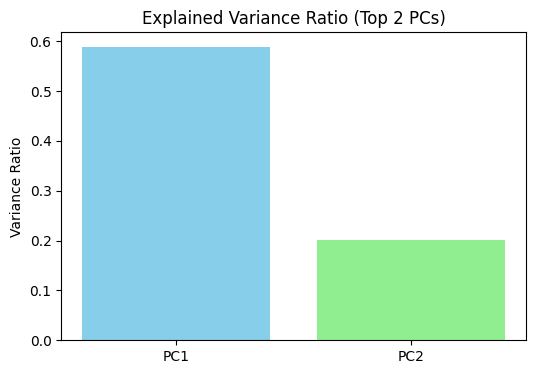

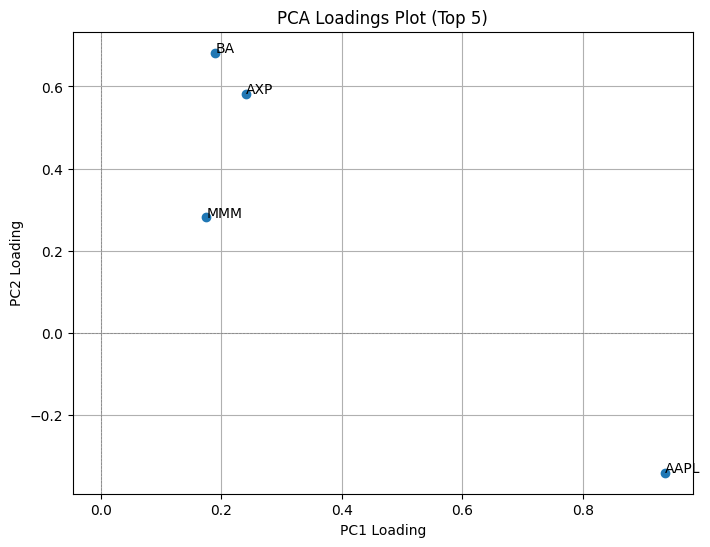

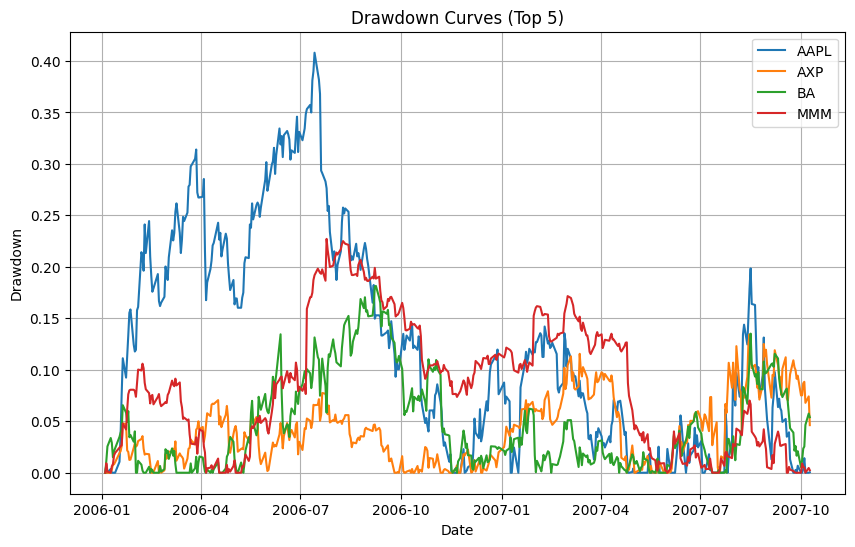


Advanced Statistics Table for Top 5 Tickers:

      Mean Daily Return  Daily Std Dev  Annualized Return  \
AAPL             0.0021         0.0235             0.5281   
AXP              0.0005         0.0132             0.1202   
BA               0.0009         0.0134             0.2297   
MMM              0.0005         0.0107             0.1221   

      Annualized Volatility  Sharpe Ratio (0 RF)  Max Drawdown  PC1 Loading  \
AAPL                 0.3723               1.4186        0.4080       0.9358   
AXP                  0.2098               0.5731        0.1344       0.2404   
BA                   0.2132               1.0777        0.1815       0.1896   
MMM                  0.1697               0.7194        0.2272       0.1747   

      PC2 Loading  
AAPL      -0.3405  
AXP        0.5823  
BA         0.6822  
MMM        0.2820  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ==============================
# ADVANCED TECHNIQUES & VISUALIZATION
# ==============================

# 1) Load and prepare data
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Close', 'Name'])
price_df = df.pivot(index='Date', columns='Name', values='Close').dropna(axis=0, how='any')
return_df = price_df.pct_change().dropna()

# 2) Identify top 5 tickers by average volume
vol_df = df.pivot(index='Date', columns='Name', values='Volume').reindex(price_df.index)
avg_vol = vol_df.mean().sort_values(ascending=False)
top5 = avg_vol.index[:5].tolist()
prices_top5 = price_df[top5]
returns_top5 = return_df[top5]

# -----------------------------------
# 3) Bollinger Bands (20-day window)
# -----------------------------------
window_bb = 20
bb_df = pd.DataFrame(index=prices_top5.index)
for ticker in top5:
    ma = prices_top5[ticker].rolling(window=window_bb).mean()
    std = prices_top5[ticker].rolling(window=window_bb).std()
    bb_df[f'{ticker}_MA'] = ma
    bb_df[f'{ticker}_Upper'] = ma + 2 * std
    bb_df[f'{ticker}_Lower'] = ma - 2 * std

# Plot Bollinger Bands
plt.figure(figsize=(14, 12))
for i, ticker in enumerate(top5, 1):
    plt.subplot(5, 1, i)
    plt.plot(prices_top5.index, prices_top5[ticker], label=f'{ticker} Price', color='blue', linewidth=1)
    plt.plot(bb_df.index, bb_df[f'{ticker}_MA'], label=f'{ticker} 20-day MA', color='orange', linewidth=1)
    plt.plot(bb_df.index, bb_df[f'{ticker}_Upper'], label='Upper Band', color='green', linestyle='--', linewidth=1)
    plt.plot(bb_df.index, bb_df[f'{ticker}_Lower'], label='Lower Band', color='red', linestyle='--', linewidth=1)
    mask = ~bb_df[[f'{ticker}_Upper', f'{ticker}_Lower']].isna().any(axis=1)
    plt.fill_between(bb_df.index[mask], bb_df[f'{ticker}_Upper'][mask], bb_df[f'{ticker}_Lower'][mask],
                     color='grey', alpha=0.1)
    plt.title(f'{ticker} Bollinger Bands (20-day)')
    plt.ylabel('Price')
    plt.legend(loc='upper left', fontsize='small')
    plt.grid(True)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# -----------------------------------
# 4) RSI (14-day) for top 5
# -----------------------------------
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_df = pd.DataFrame(index=prices_top5.index)
for ticker in top5:
    rsi_df[ticker] = compute_RSI(prices_top5[ticker])

# Plot RSI
plt.figure(figsize=(14, 12))
for i, ticker in enumerate(top5, 1):
    plt.subplot(5, 1, i)
    plt.plot(rsi_df.index, rsi_df[ticker], label=f'{ticker} RSI', color='purple', linewidth=1)
    plt.axhline(70, color='red', linestyle='--', linewidth=0.8)
    plt.axhline(30, color='green', linestyle='--', linewidth=0.8)
    plt.title(f'{ticker} 14-day RSI')
    plt.ylabel('RSI')
    plt.ylim(0, 100)
    plt.legend(loc='upper left', fontsize='small')
    plt.grid(True)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# -----------------------------------
# 5) MACD (12, 26, 9) for representative ticker
# -----------------------------------
representative = top5[0]
ema12 = prices_top5[representative].ewm(span=12, adjust=False).mean()
ema26 = prices_top5[representative].ewm(span=26, adjust=False).mean()
macd_line = ema12 - ema26
signal_line = macd_line.ewm(span=9, adjust=False).mean()

plt.figure(figsize=(10, 6))
plt.plot(prices_top5.index, macd_line, label='MACD Line', color='blue')
plt.plot(prices_top5.index, signal_line, label='Signal Line', color='red')
plt.title(f'{representative} MACD (12,26,9)')
plt.ylabel('MACD')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# -----------------------------------
# 6) Rolling 252-day correlation heatmaps (quarterly snapshots)
# -----------------------------------
window_corr = 252
snapshots = []
dates_list = prices_top5.index[window_corr::63]  # snapshots every ~63 trading days (~quarter)
for dt in dates_list:
    end_idx = prices_top5.index.get_loc(dt)
    start_idx = end_idx - window_corr + 1
    corr_mat = returns_top5.iloc[start_idx : end_idx + 1].corr()
    snapshots.append((dt, corr_mat))

plt.figure(figsize=(14, 10))
for i, (dt, corr_mat) in enumerate(snapshots[:4], 1):
    plt.subplot(2, 2, i)
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    plt.title(f'Correlation (ending {dt.date()})')
plt.tight_layout()
plt.show()

# -----------------------------------
# 7) PCA on full returns of top 5
# -----------------------------------
pca = PCA(n_components=2)
pca.fit(returns_top5.fillna(0))
loadings = pd.DataFrame(pca.components_.T, index=top5, columns=['PC1','PC2'])
explained = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(6, 4))
plt.bar(['PC1','PC2'], explained, color=['skyblue','lightgreen'])
plt.title('Explained Variance Ratio (Top 2 PCs)')
plt.ylabel('Variance Ratio')
plt.show()

# PCA loadings scatter
plt.figure(figsize=(8, 6))
plt.scatter(loadings['PC1'], loadings['PC2'])
for ticker in top5:
    plt.annotate(ticker, (loadings.loc[ticker, 'PC1'], loadings.loc[ticker, 'PC2']))
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA Loadings Plot (Top 5)')
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.grid(True)
plt.show()

# -----------------------------------
# 8) Drawdown curves for top 5
# -----------------------------------
cum_returns = (1 + returns_top5).cumprod()
rolling_max = cum_returns.cummax()
drawdowns = (rolling_max - cum_returns) / rolling_max

plt.figure(figsize=(10, 6))
for ticker in top5:
    plt.plot(drawdowns.index, drawdowns[ticker], label=ticker)
plt.title('Drawdown Curves (Top 5)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# -----------------------------------
# 9) Combined summary statistics DataFrame
# -----------------------------------
stats_df = pd.DataFrame(index=top5)
stats_df['Mean Daily Return'] = returns_top5.mean()
stats_df['Daily Std Dev'] = returns_top5.std()
stats_df['Annualized Return'] = returns_top5.mean() * 252
stats_df['Annualized Volatility'] = returns_top5.std() * np.sqrt(252)
stats_df['Sharpe Ratio (0 RF)'] = stats_df['Annualized Return'] / stats_df['Annualized Volatility']
stats_df['Max Drawdown'] = drawdowns.max()
stats_df['PC1 Loading'] = loadings['PC1']
stats_df['PC2 Loading'] = loadings['PC2']

# Print the summary table
print("\nAdvanced Statistics Table for Top 5 Tickers:\n")
print(stats_df.round(4))


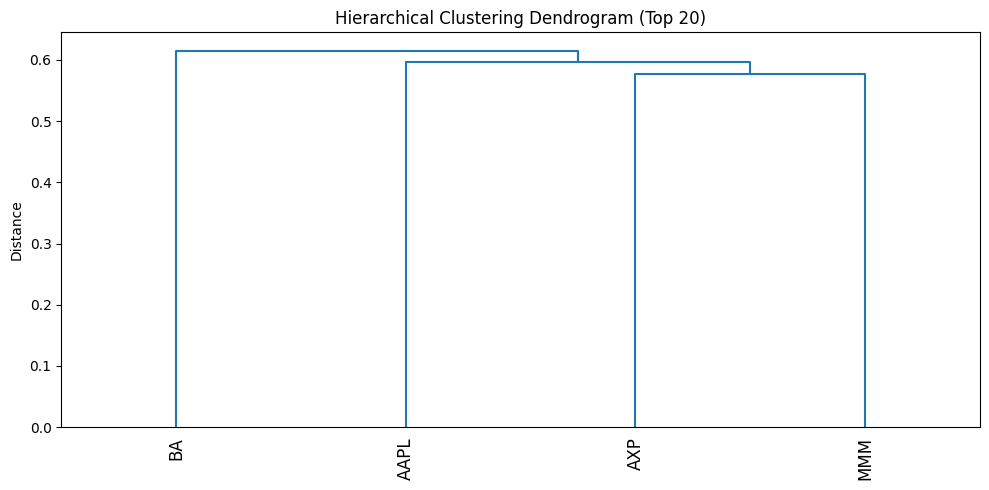

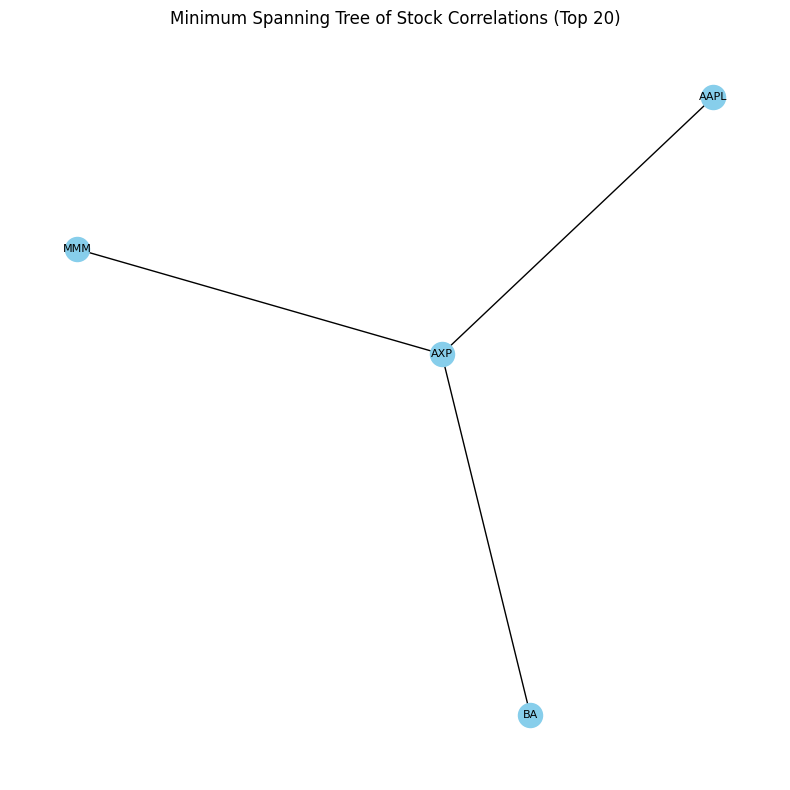

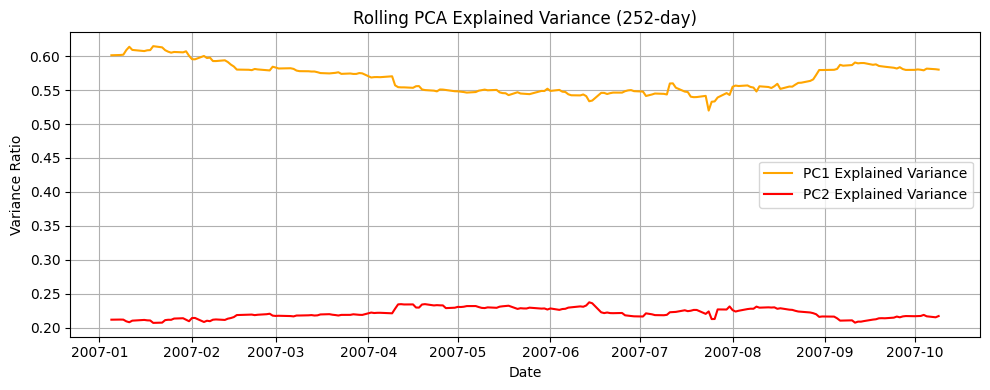

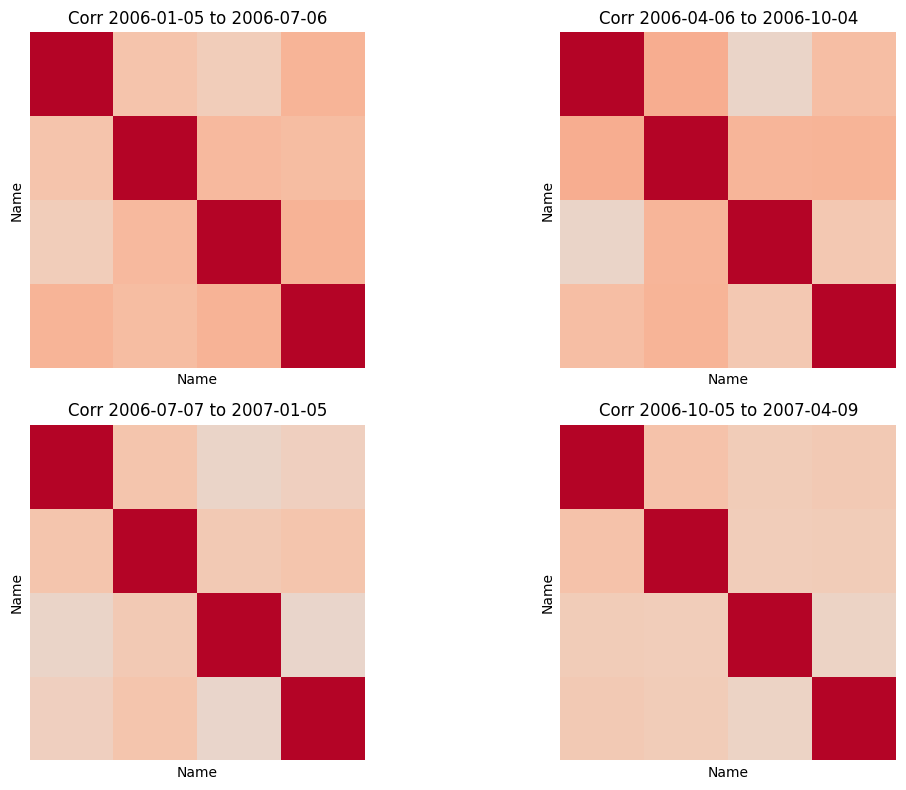

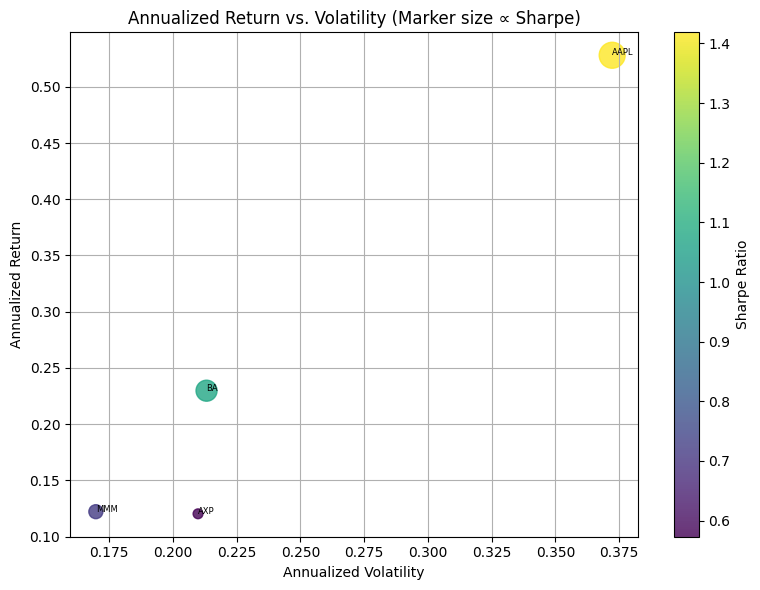


=== Summary Statistics (Top 20) ===

      Total Return  Annualized Return  Annualized Volatility  Sharpe Ratio  \
Name                                                                         
AAPL        1.2453             0.5281                 0.3723        1.4186   
BA          0.4402             0.2297                 0.2132        1.0777   
MMM         0.2087             0.1221                 0.1697        0.7194   
AXP         0.1890             0.1202                 0.2098        0.5731   

      Max Drawdown  
Name                
AAPL        0.4672  
BA          0.2291  
MMM         0.2531  
AXP         0.1676  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
import networkx as nx

# =========================
# 1) LOAD & PREPARE DATA
# =========================
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Close', 'Name'])
price_df = (
    df
    .pivot(index='Date', columns='Name', values='Close')
    .dropna(axis=0, how='any')
    .sort_index()
)
return_df = price_df.pct_change().dropna()

# -------------------------
# 2) TOP 20 BY LIQUIDITY
# -------------------------
vol_df = (
    df
    .pivot(index='Date', columns='Name', values='Volume')
    .reindex(price_df.index)
)
top20 = vol_df.mean().sort_values(ascending=False).index[:20].tolist()

prices = price_df[top20]
returns = return_df[top20]

# ============================================
# 3) HIERARCHICAL CLUSTERING & DENDROGRAM
# ============================================
# 3.1 Compute pairwise “distance” from correlation
corr = returns.corr()
dist = np.sqrt(0.5 * (1 - corr))

# 3.2 Build linkage matrix (average‐linkage)
linkage_matrix = sch.linkage(squareform(dist), method='average')

# 3.3 Plot dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix, labels=top20, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Top 20)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# ============================================
# 4) MINIMUM SPANNING TREE (MST) NETWORK
# ============================================
# 4.1 Build a complete weighted graph where edge‐weight = distance
G = nx.Graph()
for t in top20:
    G.add_node(t)

for i in range(len(top20)):
    for j in range(i+1, len(top20)):
        w = dist.iloc[i, j]
        G.add_edge(top20[i], top20[j], weight=w)

# 4.2 Compute MST
mst = nx.minimum_spanning_tree(G, weight='weight')

# 4.3 Plot MST (spring layout)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(mst, seed=42)  # for reproducible positioning
nx.draw_networkx_nodes(mst, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(mst, pos, width=1)
nx.draw_networkx_labels(mst, pos, font_size=8)
plt.title('Minimum Spanning Tree of Stock Correlations (Top 20)')
plt.axis('off')
plt.tight_layout()
plt.show()

# ============================================
# 5) ROLLING PCA EXPLAINED VARIANCE (252-day)
# ============================================
rolling_window = 252
dates = returns.index
pc1_var = []
pc2_var = []
pc_dates = []

for i in range(rolling_window, len(dates)):
    window_returns = returns.iloc[i - rolling_window : i]
    pca = PCA(n_components=2)
    pca.fit(window_returns.fillna(0))
    var = pca.explained_variance_ratio_
    pc1_var.append(var[0])
    pc2_var.append(var[1])
    pc_dates.append(dates[i])

pc1_series = pd.Series(pc1_var, index=pc_dates)
pc2_series = pd.Series(pc2_var, index=pc_dates)

plt.figure(figsize=(10, 4))
plt.plot(pc1_series.index, pc1_series.values, label='PC1 Explained Variance', color='orange')
plt.plot(pc2_series.index, pc2_series.values, label='PC2 Explained Variance', color='red')
plt.title('Rolling PCA Explained Variance (252-day)')
plt.xlabel('Date')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================
# 6) DYNAMIC CORRELATION HEATMAPS (6-month)
# ============================================
window_corr = 126   # ~6 months of trading days
step = 63          # update every ~3 months
dates_list = dates[window_corr::step]

plt.figure(figsize=(12, 8))
for idx, dt in enumerate(dates_list[:4], 1):  # show first 4 snapshots
    end_idx = dates.get_loc(dt)
    start_idx = end_idx - window_corr + 1
    corr_mat = returns.iloc[start_idx : end_idx + 1].corr()
    plt.subplot(2, 2, idx)
    sns.heatmap(
        corr_mat,
        annot=False,
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f'Corr {dates[start_idx].date()} to {dt.date()}')
plt.tight_layout()
plt.show()

# ============================================
# 7) RISK-RETURN SCATTER (SIZE ∝ SHARPE)
# ============================================
ann_ret = returns.mean() * 252
ann_vol = returns.std() * np.sqrt(252)
sharpe = ann_ret / ann_vol

plt.figure(figsize=(8, 6))
sizes = (sharpe - sharpe.min()) / (sharpe.max() - sharpe.min()) * 300 + 50
scatter = plt.scatter(ann_vol, ann_ret, s=sizes, c=sharpe, cmap='viridis', alpha=0.8)
for ticker in top20:
    plt.annotate(ticker, (ann_vol[ticker], ann_ret[ticker]), fontsize=6)
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')
plt.title('Annualized Return vs. Volatility (Marker size ∝ Sharpe)')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================
# 8) SUMMARY STATISTICS TABLE
# ============================================
cum_returns = (1 + returns).cumprod() - 1
max_dd = (cum_returns.cummax() - cum_returns).max()

stats_df = pd.DataFrame({
    'Total Return': cum_returns.iloc[-1],
    'Annualized Return': ann_ret,
    'Annualized Volatility': ann_vol,
    'Sharpe Ratio': sharpe,
    'Max Drawdown': max_dd
})
stats_df = stats_df.sort_values(by='Total Return', ascending=False)

print("\n=== Summary Statistics (Top 20) ===\n")
print(stats_df.round(4))


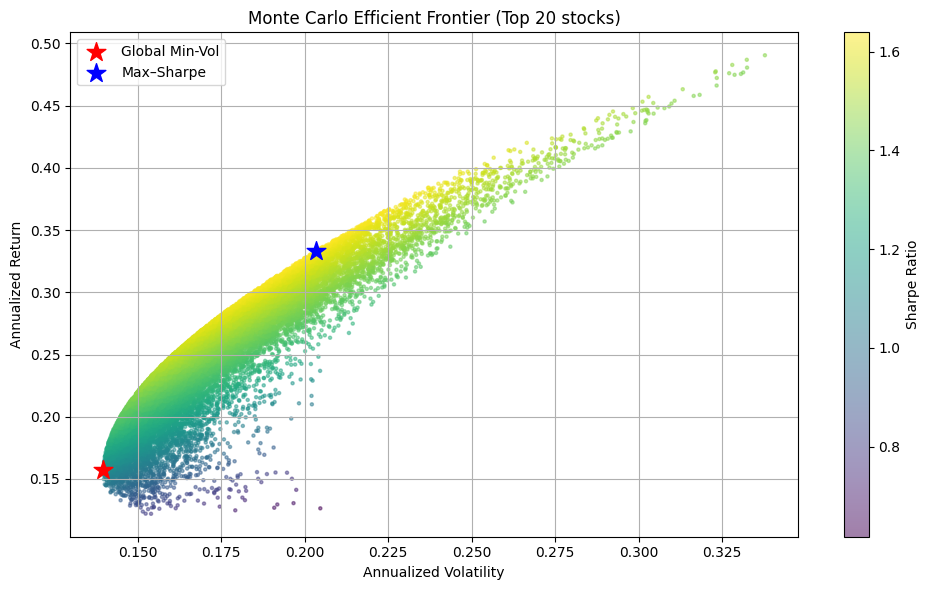

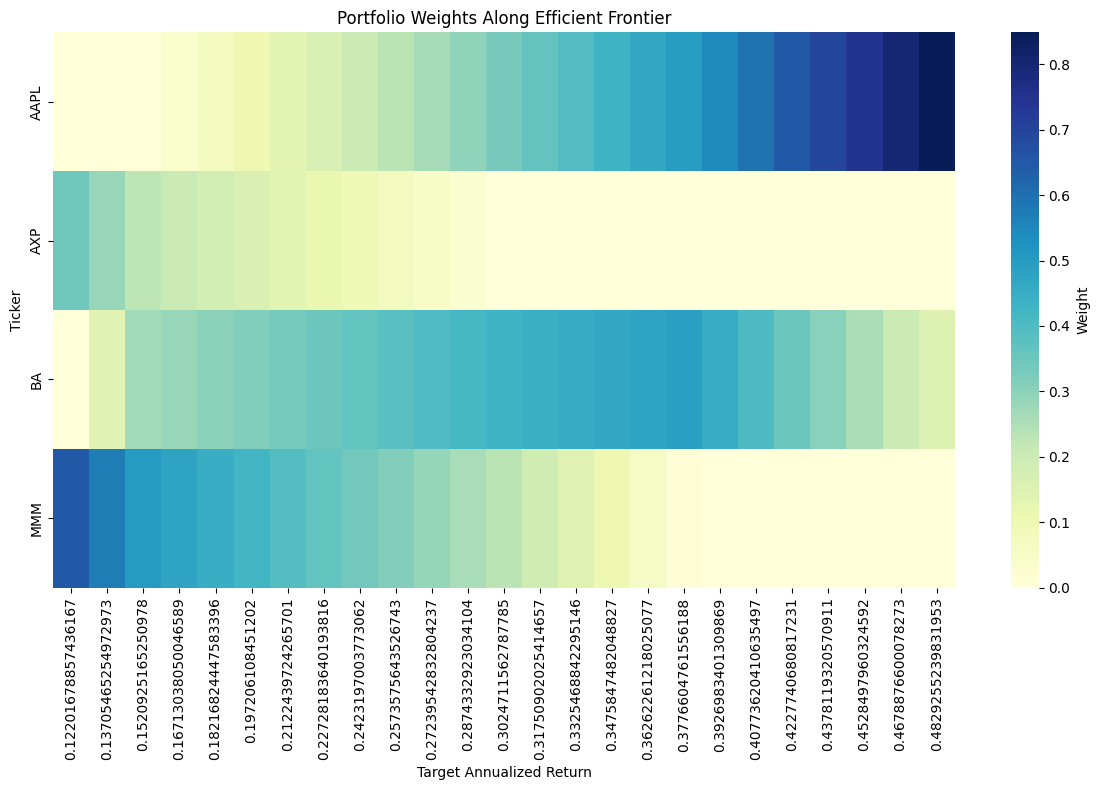

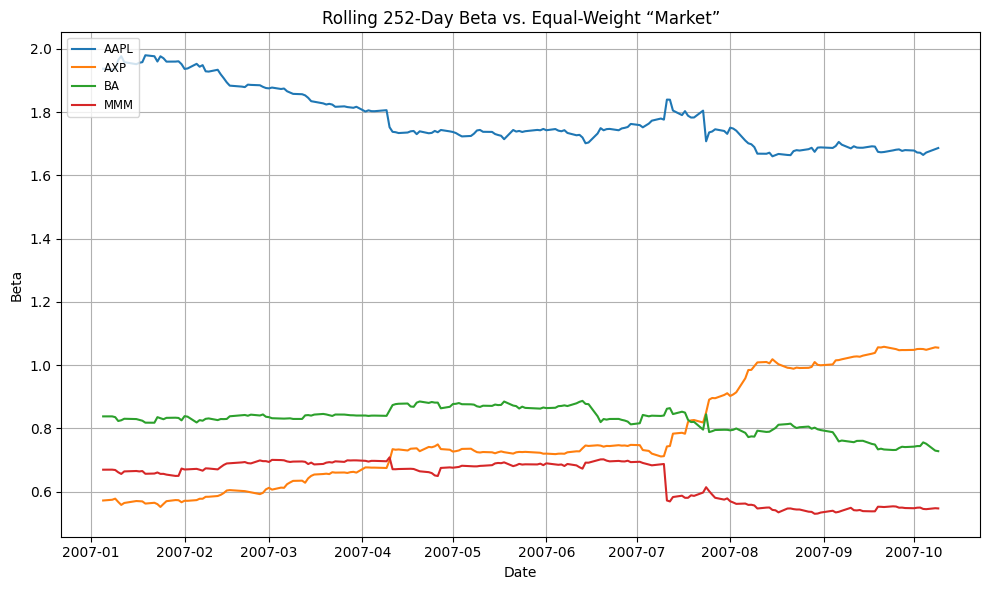

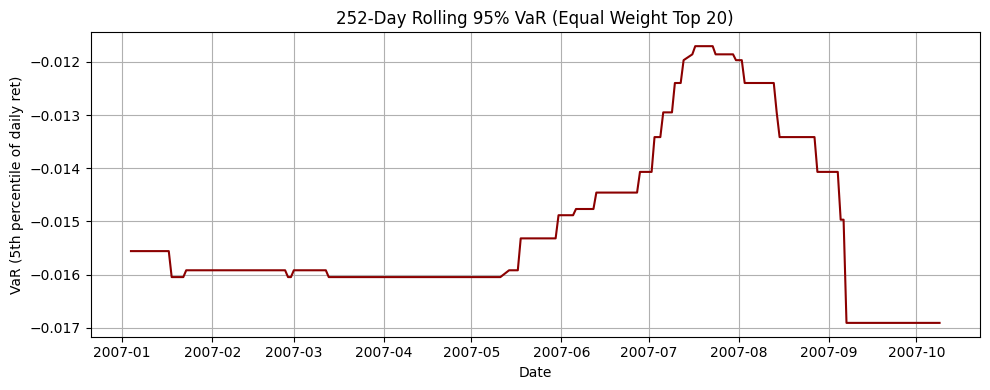


Global Minimum-Variance Portfolio Weights:

MMM     0.5038
BA      0.2651
AXP     0.2144
AAPL    0.0167
Name: 3154, dtype: float64

Max-Sharpe Portfolio Weights:

BA      0.4562
AAPL    0.3988
MMM     0.1448
AXP     0.0002
Name: 15435, dtype: float64

GMV Stats (Vol, Ret, Sharpe): [0.1396, 0.157, 1.1247]
Max-Sharpe Stats (Vol, Ret, Sharpe): [0.2032, 0.3331, 1.6391]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# ======================================
# 1) LOAD DATA & PREPARE TOP-20 UNIVERSE
# ======================================
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date','Close','Name'])
price_df = (
    df
    .pivot(index='Date', columns='Name', values='Close')
    .dropna(axis=0, how='any')
    .sort_index()
)
return_df = price_df.pct_change().dropna()

# Select top 20 tickers by average volume
vol_df = df.pivot(index='Date', columns='Name', values='Volume').reindex(price_df.index)
top20 = vol_df.mean().sort_values(ascending=False).index[:20].tolist()
prices = price_df[top20]
returns = return_df[top20]

# Compute sample mean and covariance on entire history
mu = returns.mean() * 252
cov = returns.cov() * 252

# ======================================
# 2) MONTE CARLO EFFICIENT FRONTIER
# ======================================
n_portfolios = 20000
np.random.seed(123)

results = np.zeros((n_portfolios, 3 + len(top20)))
# columns: [Volatility, Return, Sharpe, w1, w2, ..., w20]

for i in range(n_portfolios):
    # 2.1 random weights (sum to 1, nonnegative)
    w = np.random.random(len(top20))
    w /= np.sum(w)
    port_return = w.dot(mu)
    port_vol = np.sqrt(w.dot(cov).dot(w))
    port_sharpe = port_return / port_vol
    results[i, 0] = port_vol
    results[i, 1] = port_return
    results[i, 2] = port_sharpe
    results[i, 3:] = w

# Convert to DataFrame for convenience
cols = ['Volatility','Return','Sharpe'] + top20
frontier_df = pd.DataFrame(results, columns=cols)

# 2.2 Find Global Minimum-Variance portfolio (min volatility)
gmv_idx = frontier_df['Volatility'].idxmin()
gmv = frontier_df.loc[gmv_idx]

# 2.3 Find Maximum-Sharpe portfolio (assume risk-free = 0)
ms_idx = frontier_df['Sharpe'].idxmax()
ms = frontier_df.loc[ms_idx]

# 2.4 Plot Monte Carlo scatter + highlight GMV & MS
plt.figure(figsize=(10,6))
plt.scatter(frontier_df['Volatility'], frontier_df['Return'],
            c=frontier_df['Sharpe'], cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(gmv['Volatility'], gmv['Return'], c='red', marker='*', s=200, label='Global Min-Vol')
plt.scatter(ms['Volatility'], ms['Return'], c='blue', marker='*', s=200, label='Max–Sharpe')
plt.title('Monte Carlo Efficient Frontier (Top 20 stocks)')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================================
# 3) WEIGHT ALLOCATION HEATMAP ON FRONTIER
# ======================================
# 3.1 Define a grid of target returns between min and max found
target_returns = np.linspace(frontier_df['Return'].min(), frontier_df['Return'].max(), 50)

# 3.2 For each target, solve a small QP to find min-vol weights
#     subject to w'μ = target, sum(w)=1, w>=0
import cvxpy as cp

N = len(top20)
w_var = cp.Variable(N)
Sigma = cov.values
mu_vals = mu.values

w_matrix = []
ret_reached = []

for rt in target_returns:
    # minimize w' Σ w
    objective = cp.Minimize(cp.quad_form(w_var, Sigma))
    constraints = [
        w_var @ mu_vals == rt,
        cp.sum(w_var) == 1,
        w_var >= 0
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)
    if w_var.value is not None:
        w_opt = np.array(w_var.value).flatten()
        w_opt[w_opt < 1e-6] = 0.0
        w_opt /= np.sum(w_opt)
        w_matrix.append(w_opt)
        ret_reached.append(rt)

w_matrix = np.array(w_matrix)
ret_reached = np.array(ret_reached)

# 3.3 Build DataFrame: rows=target_returns, columns=top20 tickers
weights_df = pd.DataFrame(w_matrix, index=ret_reached, columns=top20)

# 3.4 Plot heatmap of weights (just pick 30 targets for visibility)
subset = weights_df.iloc[::2]  # every other target
plt.figure(figsize=(12, 8))
sns.heatmap(subset.T, cmap='YlGnBu', cbar_kws={'label': 'Weight'})
plt.title('Portfolio Weights Along Efficient Frontier')
plt.xlabel('Target Annualized Return')
plt.ylabel('Ticker')
plt.tight_layout()
plt.show()

# ======================================
# 4) ROLLING BETA VS. EQUAL-WEIGHT MARKET
# ======================================
# 4.1 Construct equal-weight “market” return
ew_weights = np.ones(len(top20)) / len(top20)
market_ret = returns.dot(ew_weights)

# 4.2 Rolling regression on 252-day windows: R_i,t = alpha + beta_i * R_m,t + ε
betas = pd.DataFrame(index=returns.index, columns=top20)

for ticker in top20:
    for i in range(252, len(returns)):
        y = returns[ticker].iloc[i-252:i]
        x = market_ret.iloc[i-252:i]
        beta = np.cov(y, x)[0,1] / np.var(x)
        betas.at[returns.index[i], ticker] = beta

betas = betas.dropna()

# 4.3 Plot a few representative betas over time
plt.figure(figsize=(10, 6))
for t in top20[:4]:  # plot first 4 stocks for clarity
    plt.plot(betas.index, betas[t], label=t)
plt.title('Rolling 252-Day Beta vs. Equal-Weight “Market”')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================================
# 5) ROLLING 95% VaR FOR EQUAL-WEIGHT PORTFOLIO
# ======================================
# 5.1 Compute daily returns of equal-weight portfolio
ew_port_ret = market_ret

# 5.2 Rolling 252-day nonparametric 95% VaR (i.e. 5th percentile)
rolling_VaR = ew_port_ret.rolling(window=252).quantile(0.05)

plt.figure(figsize=(10, 4))
plt.plot(rolling_VaR.index, rolling_VaR.values, color='darkred')
plt.title('252-Day Rolling 95% VaR (Equal Weight Top 20)')
plt.xlabel('Date')
plt.ylabel('VaR (5th percentile of daily ret)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================================
# 6) SUMMARY: SHOW BEST-PERFORMING PORTFOLIOS
# ======================================
# 6.1 Print weights of GMV and Max-Sharpe
print("\nGlobal Minimum-Variance Portfolio Weights:\n")
print(pd.Series(gmv[top20], index=top20).round(4).sort_values(ascending=False))

print("\nMax-Sharpe Portfolio Weights:\n")
print(pd.Series(ms[top20], index=top20).round(4).sort_values(ascending=False))

# 6.2 Print summary of GMV & Max-Sharpe stats
print("\nGMV Stats (Vol, Ret, Sharpe):", round(gmv[['Volatility','Return','Sharpe']], 4).tolist())
print("Max-Sharpe Stats (Vol, Ret, Sharpe):", round(ms[['Volatility','Return','Sharpe']], 4).tolist())


In [ ]:
import pandas as pd
import numpy as np

# 1. Load the dataset
# Adjust the path if necessary
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')

# Parse the Date column into datetime objects using day-month-year format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# 2. Helper function to compute Return and Volatility for each stock over a given date range
def compute_metrics(df: pd.DataFrame, start_date: pd.Timestamp, end_date: pd.Timestamp) -> pd.DataFrame:
    """
    For each stock in df, compute:
      - Return = (last closing price in period) / (first closing price in period)
      - Volatility = annualized std. dev. of daily log-returns

    Only include stocks that have at least two trading days in the period.
    """
    # Filter rows between start_date and end_date (inclusive)
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    sub = df.loc[mask].copy()

    results = {}

    # Group by stock ticker/name
    for ticker, group in sub.groupby('Name'):
        # Sort by Date ascending
        group_sorted = group.sort_values('Date')

        # Find the first available closing price on/after start_date
        # and the last available closing price on/before end_date
        try:
            first_price = group_sorted.loc[group_sorted['Date'] >= start_date, 'Close'].iloc[0]
            last_price  = group_sorted.loc[group_sorted['Date'] <= end_date,   'Close'].iloc[-1]
        except IndexError:
            # If there is no data at/after start_date or no data at/before end_date, skip
            continue

        if first_price <= 0:
            continue

        # Compute total return over the period
        total_return = last_price / first_price

        # Now compute volatility: annualized standard deviation of daily log-returns
        gr = group_sorted.set_index('Date').sort_index()
        gr_period = gr[(gr.index >= start_date) & (gr.index <= end_date)].copy()

        # Need at least two observations to compute a log-return
        if len(gr_period) < 2:
            continue

        # Compute daily log-returns
        gr_period['LogRet'] = np.log(gr_period['Close'] / gr_period['Close'].shift(1))
        gr_period = gr_period.dropna(subset=['LogRet'])

        # Annualize volatility: std(log-returns) * sqrt(252)
        vol = gr_period['LogRet'].std() * np.sqrt(252)

        results[ticker] = {
            'Return': total_return,
            'Volatility': vol
        }

    # Return as DataFrame indexed by ticker
    return pd.DataFrame.from_dict(results, orient='index')


# 3. Define the three lookback periods ending on 2018-01-01
end_date = pd.to_datetime('01-01-2018', format='%d-%m-%Y')

periods = {
    '5-year': (pd.to_datetime('01-01-2013', format='%d-%m-%Y'), end_date),
    '3-year': (pd.to_datetime('01-01-2015', format='%d-%m-%Y'), end_date),
    '1-year': (pd.to_datetime('01-01-2017', format='%d-%m-%Y'), end_date),
}

# 4. Compute the metrics for each period
metrics_by_period = {}
for label, (start_dt, end_dt) in periods.items():
    df_metrics = compute_metrics(df, start_dt, end_dt)
    # Drop any stocks with NaN or infinite values if they exist
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.nan).dropna()
    metrics_by_period[label] = df_metrics


# 5. Function to extract the Pareto‐optimal frontier
def pareto_front(df_metrics: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with columns ['Return', 'Volatility'],
    sort by Return descending, Volatility ascending, and then
    walk through the list selecting points that have strictly
    lower volatility than any previously selected point.

    The result is the Pareto‐optimal frontier for maximize(Return), minimize(Volatility).
    """
    # Sort: highest return first; if returns tie, lowest volatility first
    df_sorted = df_metrics.sort_values(['Return', 'Volatility'], ascending=[False, True])

    pareto_list = []
    best_vol_so_far = np.inf

    # Iterate through the sorted rows
    for ticker, row in df_sorted.iterrows():
        ret = row['Return']
        vol = row['Volatility']

        # Only add if this stock’s volatility is strictly lower than any previously accepted
        if vol < best_vol_so_far:
            pareto_list.append({
                'Name': ticker,
                'Return': ret,
                'Volatility': vol
            })
            best_vol_so_far = vol

    pareto_df = pd.DataFrame(pareto_list)
    return pareto_df.reset_index(drop=True)


# 6. Compute and print/display the Pareto frontiers
for label, metrics_df in metrics_by_period.items():
    pareto_df = pareto_front(metrics_df)
    print(f"\nPareto-optimal stocks for {label} period ({periods[label][0].date()} to {periods[label][1].date()}):\n")
    print(pareto_df.to_string(index=False))



Pareto-optimal stocks for 5-year period (2013-01-01 to 2018-01-01):

Name  Return  Volatility
 MMM 2.48333    0.151453

Pareto-optimal stocks for 3-year period (2015-01-01 to 2018-01-01):

Name   Return  Volatility
AAPL 1.547883    0.229086
 MMM 1.434658    0.156101

Pareto-optimal stocks for 1-year period (2017-01-01 to 2018-01-01):

Name   Return  Volatility
AAPL 1.456995    0.176371
 MMM 1.321932    0.127945


In [ ]:
!pip install investpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 15.7 MB/s eta 0:00:00
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481565 sha256=3dcc1adaee0875dee1e2580e5a971f827b3aa6c59e3c63127bb5b3e7c921bff4
  Stored in directory: /root/.cache/pip/wheels/df/e8/50/8d6a7119bc8829b70c66573d84e09873d611f9244cf5a1d1b2
Successfully built investpy


In [ ]:
import pandas as pd
import yfinance as yf

# 1) List out the tickers you want from Yahoo Finance
#    - Stocks / ETFs
stock_tickers = [
    "AAPL",    # Apple
    "MSFT",    # Microsoft
    "SPY",     # S&P 500 ETF
]

#    - Gold futures (GC=F), Crude oil (CL=F), Silver (SI=F), etc.
commodity_tickers = [
    "GC=F",    # Gold futures
    "CL=F",    # Crude Oil futures
    "SI=F",    # Silver futures
]

#    - Major FX pairs (Yahoo uses “<BASE><QUOTE>=X”)
#      e.g. EUR/USD is “EURUSD=X”, USD/JPY is “JPY=X” (because USD is implied base)
fx_tickers = [
    "EURUSD=X",  # Euro / US Dollar
    "JPY=X",     # Japanese Yen / US Dollar
    "GBPUSD=X",  # British Pound / US Dollar
]

#    - Cryptocurrencies (BTC, ETH, etc.)
crypto_tickers = [
    "BTC-USD",   # Bitcoin to USD
    "ETH-USD",   # Ethereum to USD
]

# Combine them all into one list
all_tickers = stock_tickers + commodity_tickers + fx_tickers + crypto_tickers

# 2) Download daily historical data for each ticker
#    We’ll pull Adjusted Close (which accounts for stock splits/dividends)
#    from 2015-01-01 through 2023-12-31 (you can change the date range as needed).
start_date = "2015-01-01"
end_date   = "2023-12-31"

# yf.download can take a list of tickers and return a multi‐level DataFrame.
# We'll fetch only the "Adj Close" column for simplicity.
data = yf.download(
    tickers        = all_tickers,
    start          = start_date,
    end            = end_date,
    progress       = False,
    group_by       = "ticker",      # Each ticker’s data in its own sub‐DataFrame
    auto_adjust    = False,         # We explicitly read “Adj Close” below
    threads        = True,
)

# 3) Extract each ticker’s Adjusted Close into one combined DataFrame
#    The result will be a DataFrame whose columns are the tickers, rows are Dates,
#    and values are the daily adjusted‐close price.
price_dict = {}
for t in all_tickers:
    # If the ticker does not exist or has no data, yfinance might skip it;
    # so we guard with `if t in data.columns.levels[0]`
    if t in data.columns.levels[0]:
        price_dict[t] = data[t]["Adj Close"].rename(t)

# Concatenate into one DataFrame (index = Date)
df_prices = pd.concat(price_dict.values(), axis=1)

# 4) (Optional) Drop rows where *all* tickers are NaN (e.g. weekends/holidays with no quotes for any asset)
df_prices = df_prices.dropna(how="all")

# 5) Save to disk or display
df_prices.to_csv("multi_asset_prices_2015_2023.csv")
print("→ Saved combined multi-asset CSV to 'multi_asset_prices_2015_2023.csv'")

# 6) (Optional) Show the first few rows
print(df_prices.head())


→ Saved combined multi-asset CSV to 'multi_asset_prices_2015_2023.csv'
                 AAPL       MSFT         SPY         GC=F       CL=F  \
Date                                                                   
2015-01-01        NaN        NaN         NaN          NaN        NaN   
2015-01-02  24.288582  39.998703  172.075272  1186.000000  52.689999   
2015-01-03        NaN        NaN         NaN          NaN        NaN   
2015-01-04        NaN        NaN         NaN          NaN        NaN   
2015-01-05  23.604332  39.630886  168.967606  1203.900024  50.040001   

                 SI=F  EURUSD=X       JPY=X  GBPUSD=X     BTC-USD  ETH-USD  
Date                                                                        
2015-01-01        NaN  1.209863  119.672997  1.558094  314.248993      NaN  
2015-01-02  15.734000  1.208941  119.870003  1.557972  315.032013      NaN  
2015-01-03        NaN       NaN         NaN       NaN  281.082001      NaN  
2015-01-04        NaN       NaN        